In [69]:
# load pandas and read the csv file from the url
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import numpy as np
warnings.filterwarnings("ignore")
# read local data csv
df = pd.read_csv("./stack-overflow-developer-survey-2024/survey_results_public.csv", )

# basic EDA function
def basic_info(column):
    print(df[column].head())
    print('-'*40)
    print(df[column].tail())
    print('-'*40)
    print(df[column].isnull().sum())
    print('-'*40)
    print(df[column].value_counts())
    print('-'*40)
    print('*'*40)

WaitForOneHotEncoder = [] # create a list to store the columns that need to be one-hot encoded later

# simple distribution plot function
def bin_distribution(column, bins=10,rotate=0):
    plt.figure(figsize=(12,6))
    sns.histplot(df[column], bins=bins, kde=False)
    plt.title(f'{column} Distribution')
    plt.xlabel(column)
    plt.ylabel('Count')
    # rotate x labels
    if rotate:
        plt.xticks(rotation=rotate)
    plt.show()

# don't overthink this function, it is just a fast way to explode a column with multiple values separated by a delimiter and one-hot encode the result, it is for machine learning data cleaning purpose, not for data analysis
def fast_explode(target_dataframe, target_column, fillna='', split=';', prefix='worked with', tmp_column_name='tmp_c'):
    # Step 1: Create a temporary column with split and prefix
    _exploded = (
        target_dataframe.assign(
            **{tmp_column_name: target_dataframe[target_column]
                .fillna(fillna)
                .str.split(split)
                .apply(lambda lst: [f"{prefix} {lang.strip()}" for lang in lst if lang])
            }
        )
        .explode(tmp_column_name)
    )

    # Step 2: One-hot encode
    _one_hot = pd.crosstab(index=_exploded.index, columns=_exploded[tmp_column_name]).astype(bool)

    # Step 3: Combine with original DataFrame
    print(target_column, _one_hot.shape[0], target_dataframe.shape[0])
    result = pd.concat([target_dataframe.drop(columns=[target_column]), _one_hot], axis=1)
    result[_one_hot.columns] = result[_one_hot.columns].fillna(False)

    return result

# let's take a look at the data
print(df.head())
print(df.describe())
print(df.info())

for c in df.columns:
    print(f"{c}")

   ResponseId                      MainBranch                 Age  \
0           1  I am a developer by profession  Under 18 years old   
1           2  I am a developer by profession     35-44 years old   
2           3  I am a developer by profession     45-54 years old   
3           4           I am learning to code     18-24 years old   
4           5  I am a developer by profession     18-24 years old   

            Employment RemoteWork   Check  \
0  Employed, full-time     Remote  Apples   
1  Employed, full-time     Remote  Apples   
2  Employed, full-time     Remote  Apples   
3   Student, full-time        NaN  Apples   
4   Student, full-time        NaN  Apples   

                                    CodingActivities  \
0                                              Hobby   
1  Hobby;Contribute to open-source projects;Other...   
2  Hobby;Contribute to open-source projects;Other...   
3                                                NaN   
4                                 

# we can see null values throughout all columns, few columns have filled with  full values.

# now we will look into the data and see what we can do to clean it up and make it ready for analysis.

In [70]:
# start checking..
basic_info("ResponseId")

# so response_id can be used as index
df.set_index('ResponseId', inplace=True) # setting index

0    1
1    2
2    3
3    4
4    5
Name: ResponseId, dtype: int64
----------------------------------------
65432    65433
65433    65434
65434    65435
65435    65436
65436    65437
Name: ResponseId, dtype: int64
----------------------------------------
0
----------------------------------------
ResponseId
1        1
2        1
3        1
4        1
5        1
        ..
65433    1
65434    1
65435    1
65436    1
65437    1
Name: count, Length: 65437, dtype: int64
----------------------------------------
****************************************


In [71]:
# start checking..
basic_info("MainBranch")

# main_branch seems like a categorical data, wait for one-hot encoding later
WaitForOneHotEncoder.append("MainBranch")
#TODO drop non pro

ResponseId
1    I am a developer by profession
2    I am a developer by profession
3    I am a developer by profession
4             I am learning to code
5    I am a developer by profession
Name: MainBranch, dtype: object
----------------------------------------
ResponseId
65433    I am a developer by profession
65434    I am a developer by profession
65435    I am a developer by profession
65436    I am a developer by profession
65437       I code primarily as a hobby
Name: MainBranch, dtype: object
----------------------------------------
0
----------------------------------------
MainBranch
I am a developer by profession                                                           50207
I am not primarily a developer, but I write code sometimes as part of my work/studies     6511
I am learning to code                                                                     3875
I code primarily as a hobby                                                               3334
I used to be a dev

In [73]:
basic_info("Age")
WaitForOneHotEncoder.append("Age")

ResponseId
1    Under 18 years old
2       35-44 years old
3       45-54 years old
4       18-24 years old
5       18-24 years old
Name: Age, dtype: object
----------------------------------------
ResponseId
65433    18-24 years old
65434    25-34 years old
65435    25-34 years old
65436    18-24 years old
65437    18-24 years old
Name: Age, dtype: object
----------------------------------------
0
----------------------------------------
Age
25-34 years old       23911
35-44 years old       14942
18-24 years old       14098
45-54 years old        6249
55-64 years old        2575
Under 18 years old     2568
65 years or older       772
Prefer not to say       322
Name: count, dtype: int64
----------------------------------------
****************************************


age is categorical data, we can keep it as it is. But I assume it represented register age/ working experience, not the actual age of the respondents

In [74]:
basic_info("RemoteWork")
WaitForOneHotEncoder.append("RemoteWork")
df['RemoteWork'] = df['RemoteWork'].fillna('not filled')# filling null values with 0


ResponseId
1    Remote
2    Remote
3    Remote
4       NaN
5       NaN
Name: RemoteWork, dtype: object
----------------------------------------
ResponseId
65433                                  Remote
65434                                  Remote
65435                               In-person
65436    Hybrid (some remote, some in-person)
65437                                     NaN
Name: RemoteWork, dtype: object
----------------------------------------
10631
----------------------------------------
RemoteWork
Hybrid (some remote, some in-person)    23015
Remote                                  20831
In-person                               10960
Name: count, dtype: int64
----------------------------------------
****************************************


remote_work is categorical data, we can keep it as it is. And fill the null values with 0, meaning no remote work/experience

In [75]:
basic_info("EdLevel")
WaitForOneHotEncoder.append("EdLevel")
df['EdLevel'] = df['EdLevel'].fillna('not filled')

ResponseId
1                            Primary/elementary school
2         Bachelor’s degree (B.A., B.S., B.Eng., etc.)
3      Master’s degree (M.A., M.S., M.Eng., MBA, etc.)
4    Some college/university study without earning ...
5    Secondary school (e.g. American high school, G...
Name: EdLevel, dtype: object
----------------------------------------
ResponseId
65433         Bachelor’s degree (B.A., B.S., B.Eng., etc.)
65434                                                  NaN
65435         Bachelor’s degree (B.A., B.S., B.Eng., etc.)
65436    Secondary school (e.g. American high school, G...
65437                                                  NaN
Name: EdLevel, dtype: object
----------------------------------------
4653
----------------------------------------
EdLevel
Bachelor’s degree (B.A., B.S., B.Eng., etc.)                                          24942
Master’s degree (M.A., M.S., M.Eng., MBA, etc.)                                       15557
Some college/university study 

In [76]:
basic_info("Check")
# only 1 value drop this column
df.drop(columns=['Check'], inplace=True)

ResponseId
1    Apples
2    Apples
3    Apples
4    Apples
5    Apples
Name: Check, dtype: object
----------------------------------------
ResponseId
65433    Apples
65434    Apples
65435    Apples
65436    Apples
65437    Apples
Name: Check, dtype: object
----------------------------------------
0
----------------------------------------
Check
Apples    65437
Name: count, dtype: int64
----------------------------------------
****************************************


In [77]:
# CodingActivities
basic_info("CodingActivities")
df = fast_explode(df,target_column='CodingActivities', fillna='', split=';', prefix='coding_activities ')


ResponseId
1                                                Hobby
2    Hobby;Contribute to open-source projects;Other...
3    Hobby;Contribute to open-source projects;Other...
4                                                  NaN
5                                                  NaN
Name: CodingActivities, dtype: object
----------------------------------------
ResponseId
65433                        Hobby;School or academic work
65434             Hobby;Contribute to open-source projects
65435                                                Hobby
65436    Hobby;Contribute to open-source projects;Profe...
65437                                                  NaN
Name: CodingActivities, dtype: object
----------------------------------------
10971
----------------------------------------
CodingActivities
Hobby                                                                                                                                                                              9993
I 

1    Employed, full-time
2    Employed, full-time
3    Employed, full-time
4     Student, full-time
5     Student, full-time
Name: Employment, dtype: object
----------------------------------------
65433    Employed, full-time
65434    Employed, full-time
65435    Employed, full-time
65436    Employed, full-time
65437     Student, full-time
Name: Employment, dtype: object
----------------------------------------
0
----------------------------------------
Employment
Employed, full-time                                                                                                                                   39041
Independent contractor, freelancer, or self-employed                                                                                                   4846
Student, full-time                                                                                                                                     4709
Employed, full-time;Independent contractor, freelancer, or sel

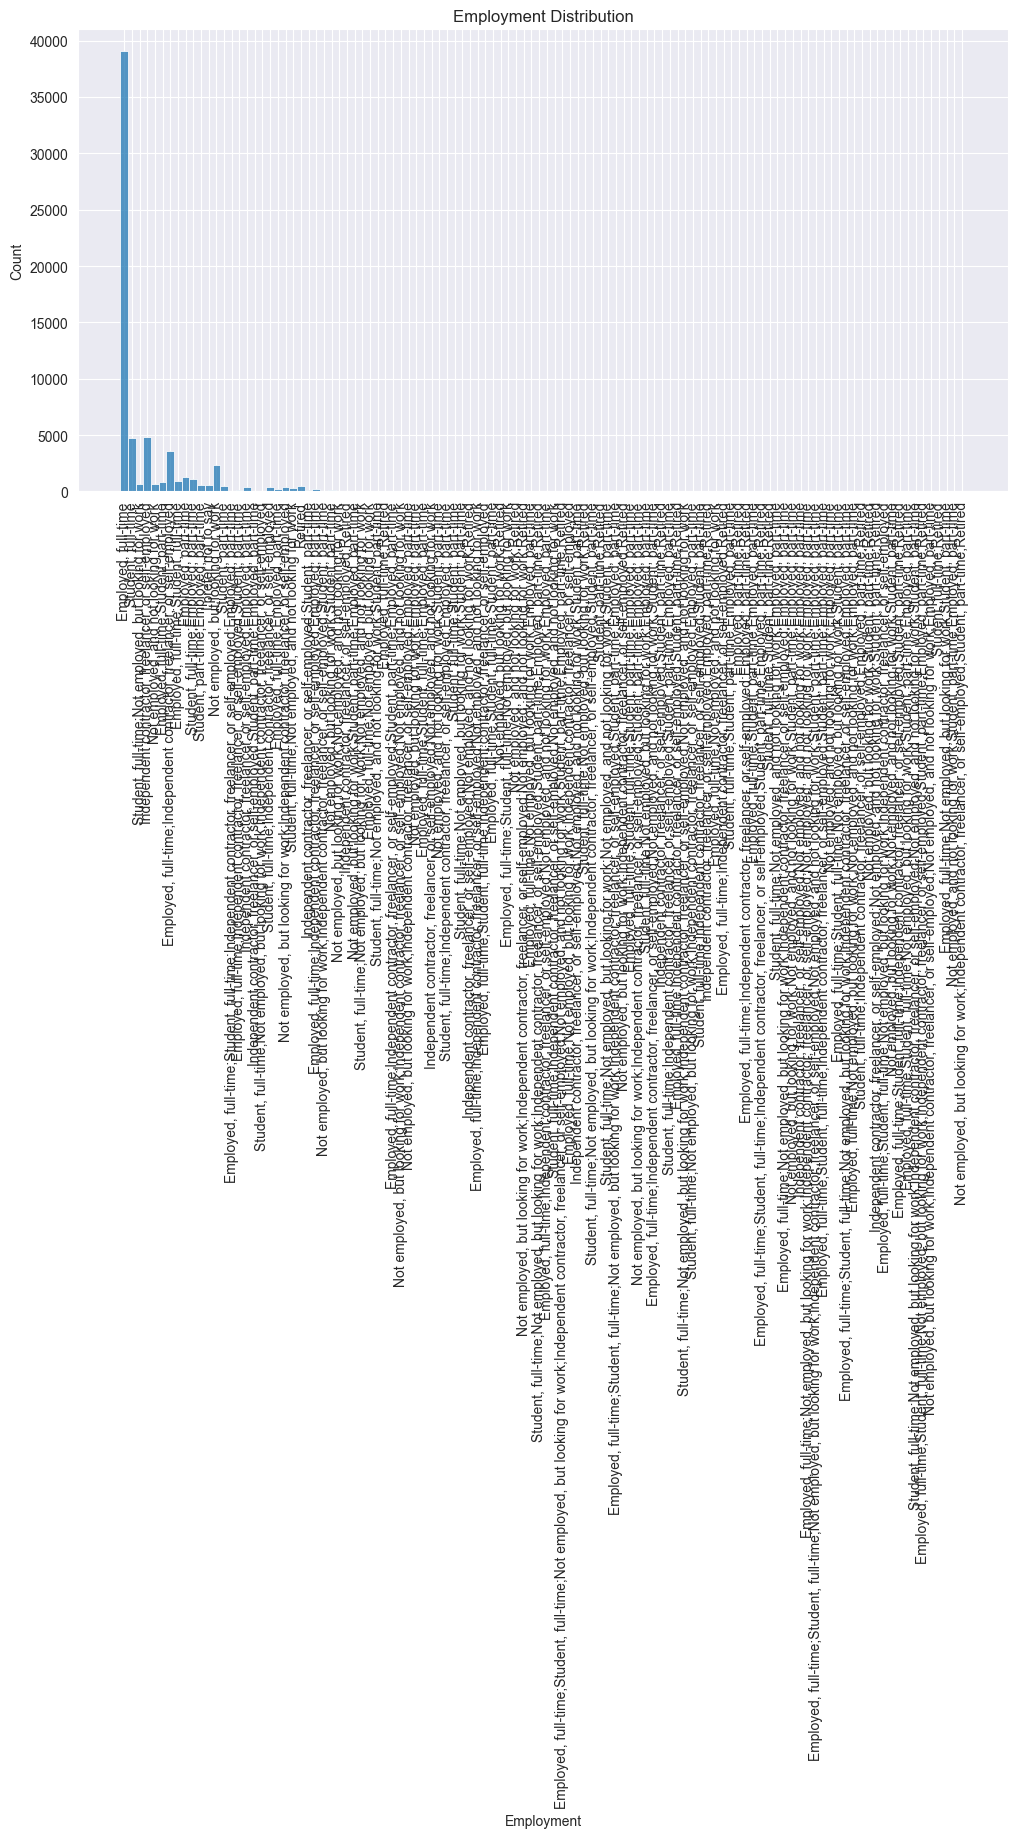

In [78]:
basic_info("Employment")
WaitForOneHotEncoder.append("Employment")
df['Employment'] = df['Employment'].fillna('not filled')
# plot distribution of Employment column
bin_distribution("Employment", bins=len(df['Employment'].unique())+1,rotate=90)



In [79]:
# categorical data, a lot null values
basic_info('LearnCode')
basic_info('LearnCodeOnline')
basic_info('TechDoc')
for col in ['LearnCode', 'LearnCodeOnline', 'TechDoc']:
    df = fast_explode(df,target_column=col, fillna='', split=';', prefix=f'{col} ')


1                               Books / Physical media
2    Books / Physical media;Colleague;On the job tr...
3    Books / Physical media;Colleague;On the job tr...
4    Other online resources (e.g., videos, blogs, f...
5    Other online resources (e.g., videos, blogs, f...
Name: LearnCode, dtype: object
----------------------------------------
65433    On the job training;School (i.e., University, ...
65434                                                  NaN
65435    Other online resources (e.g., videos, blogs, f...
65436    On the job training;Other online resources (e....
65437                                                  NaN
Name: LearnCode, dtype: object
----------------------------------------
4949
----------------------------------------
LearnCode
Other online resources (e.g., videos, blogs, forum, online community)                                                                                                 3674
Books / Physical media;Other online resources (e.g., videos

1    NaN
2     20
3     37
4      4
5      9
Name: YearsCode, dtype: object
----------------------------------------
65433      5
65434    NaN
65435      9
65436      5
65437    NaN
Name: YearsCode, dtype: object
----------------------------------------
5568
----------------------------------------
YearsCode
10                    4561
5                     3723
6                     3496
8                     3449
7                     3333
4                     3290
15                    2813
20                    2636
12                    2559
3                     2518
9                     2251
14                    1822
25                    1671
2                     1642
11                    1636
13                    1477
30                    1461
16                    1401
18                    1228
17                    1038
40                     993
24                     870
22                     842
35                     735
1                      712
23             

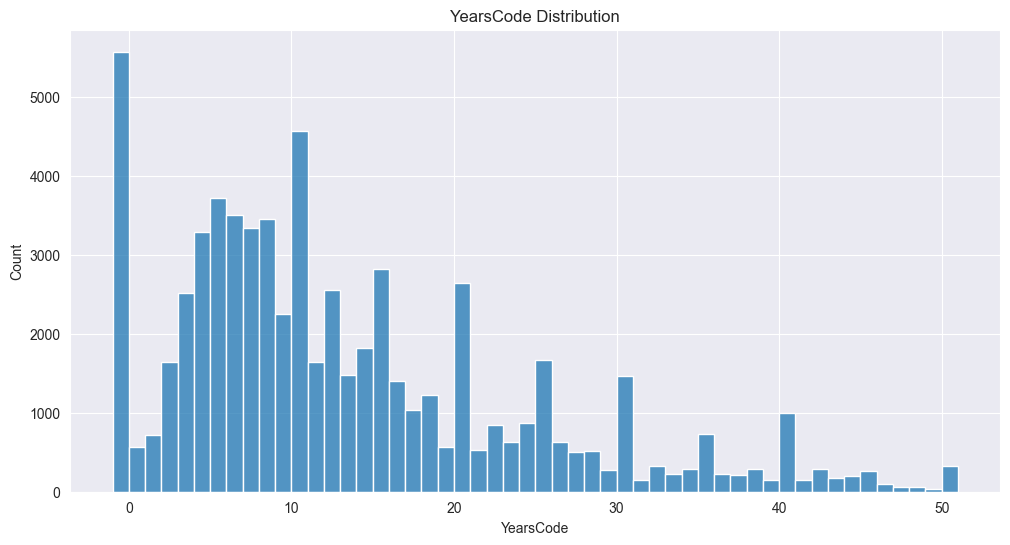

In [80]:
basic_info('YearsCode')
# 2 unique string values 'Less than 1 year' and 'More than 50 years'
# convert them to 0 and 51
df['YearsCode'] = df['YearsCode'].replace({'Less than 1 year': 0, 'More than 50 years': 51})
basic_info("YearsCode")
# need to handle the null values
df['YearsCode'] = df['YearsCode'].fillna(-1)
df['YearsCode'] = df['YearsCode'].astype(int)
bin_distribution('YearsCode', bins=52)

1    NaN
2     17
3     27
4    NaN
5    NaN
Name: YearsCodePro, dtype: object
----------------------------------------
65433      3
65434    NaN
65435      5
65436      2
65437    NaN
Name: YearsCodePro, dtype: object
----------------------------------------
13827
----------------------------------------
YearsCodePro
2                     4168
3                     4093
5                     3526
10                    3251
4                     3215
Less than 1 year      2856
6                     2843
1                     2639
8                     2549
7                     2517
12                    1777
15                    1635
20                    1549
9                     1493
11                    1312
13                    1127
14                    1082
25                     998
16                     946
18                     867
17                     814
30                     689
24                     632
19                     516
22                     492
23   

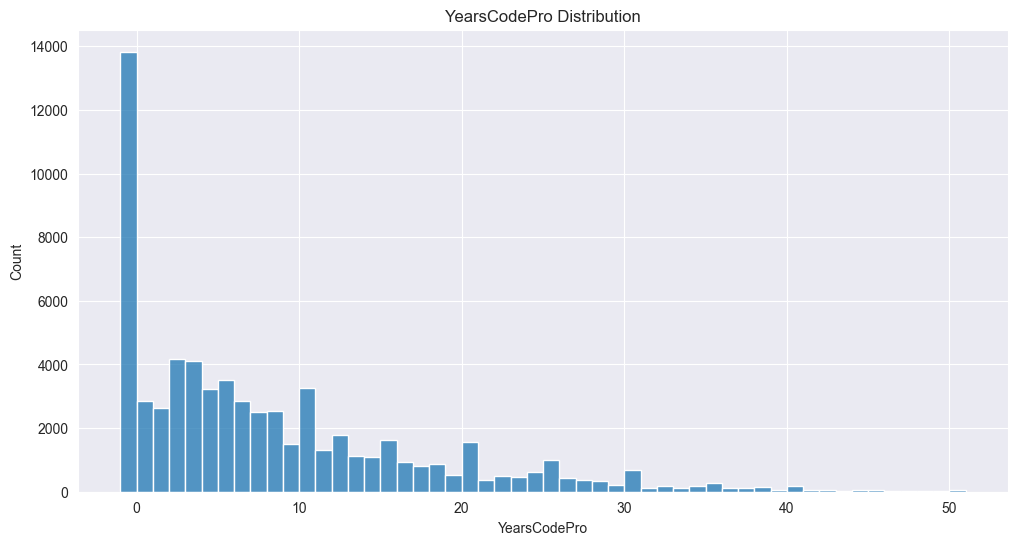

In [81]:
basic_info('YearsCodePro')
df['YearsCodePro'] = df['YearsCodePro'].replace({'Less than 1 year': 0, 'More than 50 years': 51})
basic_info("YearsCodePro")
# need to handle the null values
df['YearsCodePro'] = df['YearsCodePro'].fillna(-1)

df['YearsCodePro'] = df['YearsCodePro'].astype(int)
bin_distribution('YearsCodePro', bins=52)

1                      NaN
2    Developer, full-stack
3     Developer Experience
4    Developer, full-stack
5    Developer, full-stack
Name: DevType, dtype: object
----------------------------------------
65433             Blockchain
65434                    NaN
65435      Developer, mobile
65436    Developer, back-end
65437                    NaN
Name: DevType, dtype: object
----------------------------------------
5992
----------------------------------------
DevType
Developer, full-stack                            18260
Developer, back-end                               9928
Student                                           5102
Developer, front-end                              3349
Developer, desktop or enterprise applications     2493
Other (please specify):                           2458
Developer, mobile                                 2021
Developer, embedded applications or devices       1623
Engineering manager                               1275
Academic researcher            

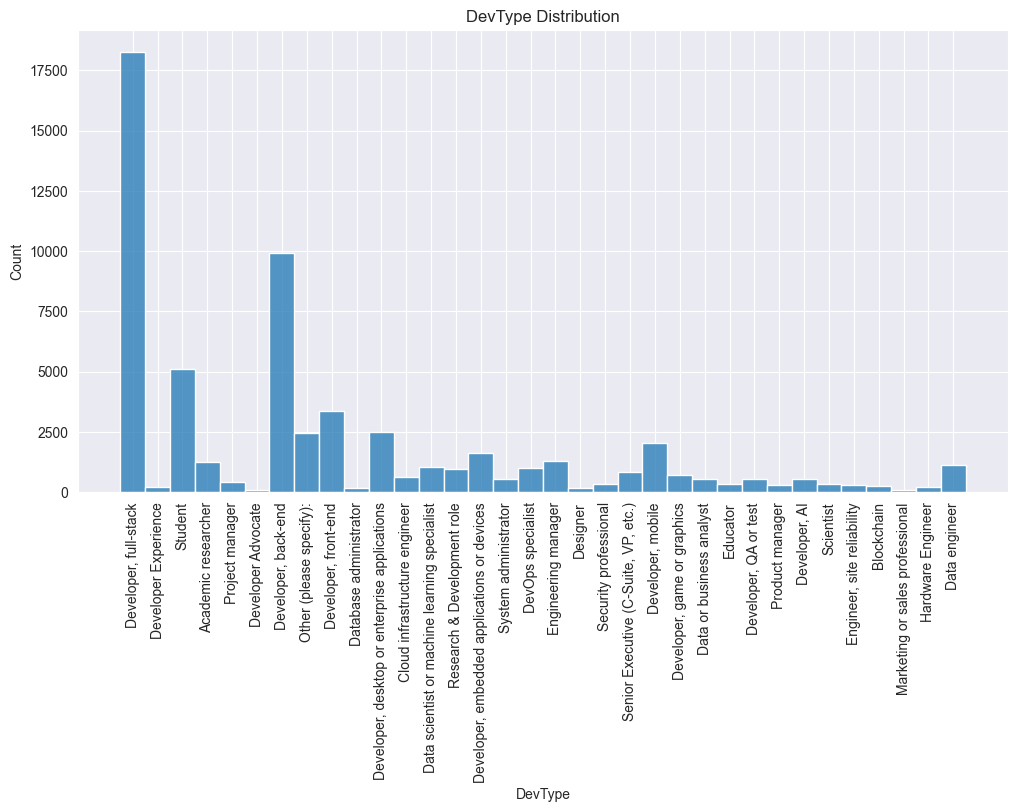

In [82]:
basic_info("DevType")
bin_distribution('DevType', bins=df['DevType'].nunique()+1,rotate=90)
WaitForOneHotEncoder.append("DevType")
df['DevType'] = df['DevType'].fillna('not filled')




1    NaN
2    NaN
3    NaN
4    NaN
5    NaN
Name: OrgSize, dtype: object
----------------------------------------
65433            2 to 9 employees
65434                         NaN
65435    1,000 to 4,999 employees
65436          20 to 99 employees
65437                         NaN
Name: OrgSize, dtype: object
----------------------------------------
17957
----------------------------------------
OrgSize
20 to 99 employees                                    9754
100 to 499 employees                                  8694
10,000 or more employees                              5558
1,000 to 4,999 employees                              5353
2 to 9 employees                                      4833
10 to 19 employees                                    4084
500 to 999 employees                                  3183
Just me - I am a freelancer, sole proprietor, etc.    3086
5,000 to 9,999 employees                              1867
I don’t know                                          1068


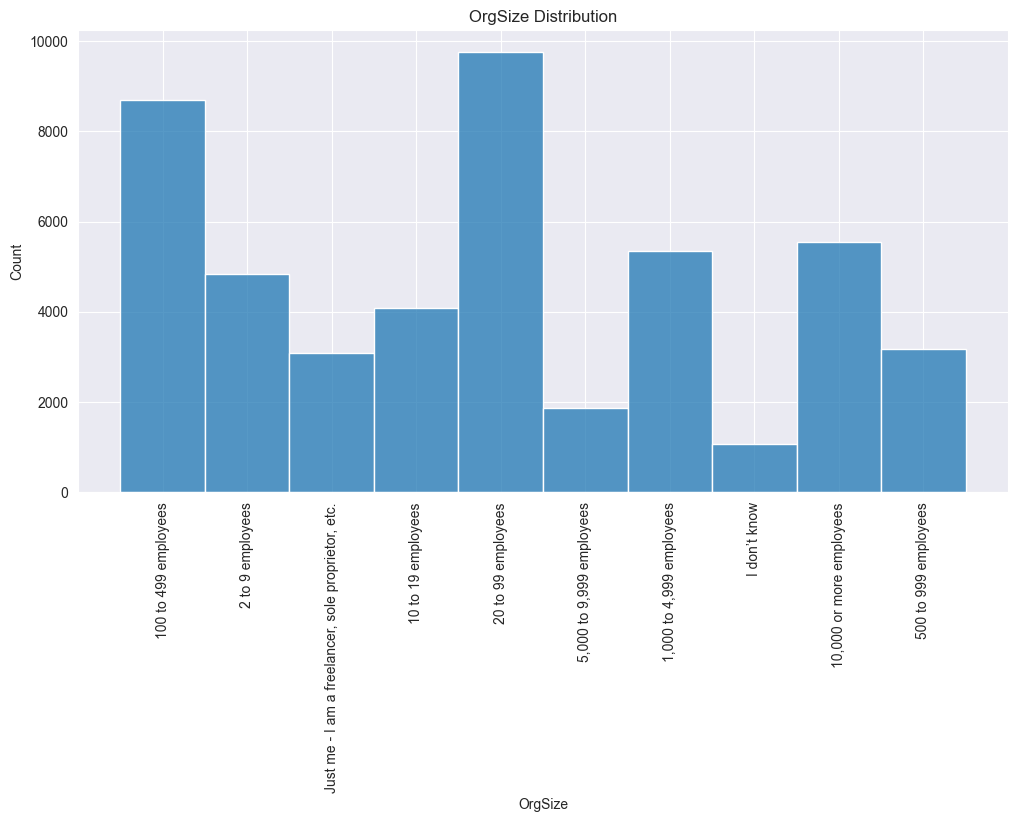

In [83]:
basic_info("OrgSize")
bin_distribution('OrgSize', bins=df['OrgSize'].nunique()+1,rotate=90)
# categorical data, a lot null values, fill null with -1 meaning no response/don't have an organization?
WaitForOneHotEncoder.append("OrgSize")
df['OrgSize'] = df['OrgSize'].fillna('not filled')




In [84]:
basic_info("PurchaseInfluence")
WaitForOneHotEncoder.append("PurchaseInfluence")
df['PurchaseInfluence'] = df['PurchaseInfluence'].fillna('not filled')


1    NaN
2    NaN
3    NaN
4    NaN
5    NaN
Name: PurchaseInfluence, dtype: object
----------------------------------------
65433            I have some influence
65434                              NaN
65435    I have little or no influence
65436            I have some influence
65437                              NaN
Name: PurchaseInfluence, dtype: object
----------------------------------------
18031
----------------------------------------
PurchaseInfluence
I have some influence               19197
I have little or no influence       17942
I have a great deal of influence    10267
Name: count, dtype: int64
----------------------------------------
****************************************


In [85]:
basic_info("BuyNewTool")# another need to expand categorial data
df = fast_explode(df,target_column='BuyNewTool', fillna='', split=';', prefix='buy_new_tool ')

basic_info('BuildvsBuy')
# don't plot this for the name is so long

WaitForOneHotEncoder.append("BuildvsBuy")
# filling null values with -1, meaning?
#TODO meaning?
df['BuildvsBuy'] = df['BuildvsBuy'].fillna('not filled')



1    NaN
2    NaN
3    NaN
4    NaN
5    NaN
Name: BuyNewTool, dtype: object
----------------------------------------
65433    Ask developers I know/work with;Ask a generati...
65434                                                  NaN
65435    Ask developers I know/work with;Ask a generati...
65436    Start a free trial;Ask developers I know/work ...
65437                                                  NaN
Name: BuyNewTool, dtype: object
----------------------------------------
20256
----------------------------------------
BuyNewTool
Start a free trial;Ask developers I know/work with;Visit developer communities like Stack Overflow                                                                            6619
Start a free trial;Ask developers I know/work with                                                                                                                            4927
Start a free trial;Ask developers I know/work with;Visit developer communities like Stack Overflow

In [86]:
basic_info("LanguageHaveWorkedWith")
drop_columns = []
explode_columns = []
for col in df.columns:
    if 'HaveWorkedWith' in col:
        explode_columns.append(col)

    elif  'Admired' in col or 'WantTo' in col or 'SO' in col or 'AI' in col:
        drop_columns.append(col)

print(drop_columns)
print(explode_columns)
# drop first
df.drop(columns=drop_columns, inplace=True)

# expand
for col in explode_columns:
    df = fast_explode(df,target_column=col, fillna='', split=';', prefix=f'{col} ')
print(df.isnull().sum())

# Splits each string in LanguageHaveWorkedWith into a list of languages，Creates a new column called Language in the DataFrame. Converts each list in Language into multiple rows.
# df = fast_explode(df,target_column='LanguageHaveWorkedWith', fillna='', split=';', prefix='worked_with ')


1                                                  NaN
2    Bash/Shell (all shells);Go;HTML/CSS;Java;JavaS...
3                                                   C#
4    C;C++;HTML/CSS;Java;JavaScript;PHP;PowerShell;...
5              C++;HTML/CSS;JavaScript;Lua;Python;Rust
Name: LanguageHaveWorkedWith, dtype: object
----------------------------------------
65433                                                 NaN
65434                                                 NaN
65435                                                 NaN
65436            C;C++;Go;Lua;Objective-C;Python;Rust;SQL
65437    C;HTML/CSS;Java;JavaScript;PHP;Python;TypeScript
Name: LanguageHaveWorkedWith, dtype: object
----------------------------------------
5692
----------------------------------------
LanguageHaveWorkedWith
HTML/CSS;JavaScript;TypeScript                            1002
Python                                                     832
HTML/CSS;JavaScript;PHP;SQL                                503
HTML/CS

In [87]:
basic_info('ICorPM') #Individual Contributor or People Manager
# categorical data, a lot null values, fill null with -1
WaitForOneHotEncoder.append("ICorPM")
df['ICorPM'] = df['ICorPM'].fillna('not filled')



1                       NaN
2    Individual contributor
3                       NaN
4                       NaN
5                       NaN
Name: ICorPM, dtype: object
----------------------------------------
65433                       NaN
65434                       NaN
65435                       NaN
65436    Individual contributor
65437                       NaN
Name: ICorPM, dtype: object
----------------------------------------
35636
----------------------------------------
ICorPM
Individual contributor    25888
People manager             3913
Name: count, dtype: int64
----------------------------------------
****************************************


In [88]:
basic_info('WorkExp')
# numerical categorical data, a lot null values, fill null with -1
df['WorkExp'] = df['WorkExp'].fillna(-1)

basic_info('Knowledge_1')
# from Knowledge_1 ~9 check the survey question, it is the long question about different things
for i in range(1,10):
    basic_info(f'Knowledge_{i}')
    WaitForOneHotEncoder.append(f'Knowledge_{i}')
    df[f'Knowledge_{i}'] = df[f'Knowledge_{i}'].fillna('not filled')

# Frequency_1 ~ 3 also
for i in range(1,4):
    basic_info(f'Frequency_{i}')
    WaitForOneHotEncoder.append(f'Frequency_{i}')
    df[f'Frequency_{i}'] = df[f'Frequency_{i}'].fillna('not filled')

basic_info('TimeSearching')
WaitForOneHotEncoder.append("TimeSearching")
df['TimeSearching'] = df['TimeSearching'].fillna('not filled')

basic_info('TimeAnswering')
WaitForOneHotEncoder.append("TimeAnswering")
df['TimeAnswering'] = df['TimeAnswering'].fillna('not filled')

basic_info('Frustration')
# change it's name to Challenge_Frustration
df.rename(columns={'Frustration': 'Challenge_Frustration'}, inplace=True)
WaitForOneHotEncoder.append("Challenge_Frustration")
df['Challenge_Frustration'] = df['Challenge_Frustration'].fillna('not filled')


basic_info('ProfessionalTech')
# change name to Company_ProfessionalTech
df.rename(columns={'ProfessionalTech': 'Company_ProfessionalTech'}, inplace=True)
WaitForOneHotEncoder.append("Company_ProfessionalTech")
df['Company_ProfessionalTech'] = df['Company_ProfessionalTech'].fillna('not filled')

basic_info('ProfessionalCloud')
WaitForOneHotEncoder.append("ProfessionalCloud")
df['ProfessionalCloud'] = df['ProfessionalCloud'].fillna('not filled')


basic_info('ProfessionalQuestion')
# change name to FirstAnswer(er)_ProfessionalQuestion
df.rename(columns={'ProfessionalQuestion': 'FirstAnswerer_ProfessionalQuestion'}, inplace=True)
WaitForOneHotEncoder.append("FirstAnswerer_ProfessionalQuestion")
df['FirstAnswerer_ProfessionalQuestion'] = df['FirstAnswerer_ProfessionalQuestion'].fillna('not filled')


basic_info('Industry')
WaitForOneHotEncoder.append("Industry")
df['Industry'] = df['Industry'].fillna('not filled')



1     NaN
2    17.0
3     NaN
4     NaN
5     NaN
Name: WorkExp, dtype: float64
----------------------------------------
65433    NaN
65434    NaN
65435    NaN
65436    5.0
65437    NaN
Name: WorkExp, dtype: float64
----------------------------------------
35779
----------------------------------------
WorkExp
3.0     2144
5.0     2050
10.0    2029
2.0     1885
4.0     1767
6.0     1600
7.0     1581
8.0     1554
1.0     1461
15.0    1250
12.0    1249
20.0    1074
9.0      982
11.0     823
25.0     794
13.0     740
14.0     655
16.0     600
17.0     596
18.0     587
30.0     461
24.0     382
19.0     330
22.0     323
23.0     269
26.0     254
21.0     251
27.0     217
35.0     217
28.0     210
0.0      192
40.0     139
29.0     117
32.0     101
33.0      90
36.0      89
34.0      84
31.0      83
37.0      60
38.0      55
50.0      53
42.0      47
45.0      46
39.0      37
41.0      36
43.0      34
44.0      32
46.0      12
48.0       7
47.0       5
49.0       4
Name: count, dtype: int64

In [89]:
basic_info("TechEndorse")
basic_info("Country") # do keep this for later analysis
basic_info("Currency") # their salary is in this currency
basic_info("CompTotal") # salary! for a year?!
# CompTotal means total compensation, including bonus, etc, not just base salary
# so it is a numerical data
df['CompTotal'] = df['CompTotal'].fillna(0)

print(df['Currency'].unique())
# keep first 3 letters of the currency that is not null

df['Currency'] = df['Currency'].str[:3]
print(df['Currency'].value_counts())
# using gpt to get the currency to usd exchange rate
usd_avg_rates_2024 = {
    "AUD": 1.5158,     # Australian dollar
    "BRL": 5.3872,     # Brazilian real
    "CAD": 1.3699,     # Canadian dollar
    "CNY": 7.1957,     # Chinese Yuan Renminbi
    "DKK": 6.8955,     # Danish krone
    "EUR": 1.0820,     # European Euro
    "HKD": 7.8030,     # Hong Kong dollar
    "INR": 83.6566,    # Indian rupee
    "JPY": 151.4551,   # Japanese yen
    "MYR": 4.5747,     # Malaysian ringgit
    "MXN": 18.3062,    # Mexican peso
    "NZD": 1.6529,     # New Zealand dollar
    "NOK": 10.7574,    # Norwegian krone
    "SGD": 1.3363,     # Singapore dollar
    "ZAR": 18.3346,    # South African rand
    "KRW": 1363.4381,  # South Korean won
    "LKR": 301.6752,   # Sri Lankan rupee
    "SEK": 10.5744,    # Swedish krona
    "CHF": 0.8808,     # Swiss franc
    "TWD": 32.1064,    # New Taiwan dollar
    "THB": 35.2845,    # Thai baht
    "GBP": 1.2781,     # Pound sterling
    "VES": 38.3314     # Venezuelan bolivar
}
# convert all salary to usd
print(df[['CompTotal']].describe())
print(df['CompTotal'].max())


'''
# I use 4 steps to initially remove outliners
# first remove smaller than 1000 usd per year
# second remove outliners by total compensation keep quantile 1~99 data
# third remove outliners by currency keep quantile 1~99 data
# fourth remove outliners by country keep quantile 1~99 data
'''

# remove smaller than 1000 usd per year
df = df.loc[(df['CompTotal'] >= 1000)]
# remove outliners by total compensation keep quantile 1~99 data
lower_bound = df['CompTotal'].quantile(0.01)
upper_bound = df['CompTotal'].quantile(0.99)
df = df[(df['CompTotal'] >= lower_bound) & (df['CompTotal'] <= upper_bound)]

# remove outliners by currency keep quantile 1~99 data
for currency in df['Currency'].unique():
    currency_mask = df['Currency'] == currency
    lower_bound = df.loc[currency_mask, 'CompTotal'].quantile(0.01)
    upper_bound = df.loc[currency_mask, 'CompTotal'].quantile(0.99)
    df = df[~((currency_mask) & ((df['CompTotal'] < lower_bound) | (df['CompTotal'] > upper_bound)))]

# remove outliners by country keep quantile 1~99 data
for country in df['Country'].unique():
    country_mask = df['Country'] == country
    lower_bound = df.loc[country_mask, 'CompTotal'].quantile(0.01)
    upper_bound = df.loc[country_mask, 'CompTotal'].quantile(0.99)
    df = df[~((country_mask) & ((df['CompTotal'] < lower_bound) | (df['CompTotal'] > upper_bound)))]



df['CompTotal'] = df.apply(lambda row: row['CompTotal'] / usd_avg_rates_2024[row['Currency']] if row['Currency'] in usd_avg_rates_2024 and row['CompTotal']>0 else row['CompTotal'], axis=1)
#remove salaries below 1000 usd per year ,remove larger than 300000 usd per year


# Example: df['CompTotal'].value_counts()
salary_counts = df['CompTotal'].value_counts()
import plotly.express as px
# Convert to DataFrame
df_salary = salary_counts.reset_index()
df_salary.columns = ['Salary', 'Count']
fig = px.histogram(
    df_salary,
    x='Salary',
    y='Count',
    nbins=100,  # Adjust bins for granularity
    title='Salary Distribution Histogram',
    labels={'Salary': 'Salary Amount', 'Count': 'Number of People'},
    log_y=False  # Log scale for better visibility
)

fig.show()
# Plot histogram (weighted by Count)
fig = px.histogram(
    df_salary,
    x='Salary',
    y='Count',
    nbins=100,  # Adjust bins for granularity
    title='Salary Distribution Histogram (log scale)',
    labels={'Salary': 'Salary Amount', 'Count': 'Number of People'},
    log_y=True  # Log scale for better visibility
)

fig.show()


1    NaN
2    NaN
3    NaN
4    NaN
5    NaN
Name: TechEndorse, dtype: object
----------------------------------------
65433    APIs;Integrated developer community;Quality su...
65434                                                  NaN
65435                                                  NaN
65436    APIs;Customization;Connected to an open source...
65437                                                  NaN
Name: TechEndorse, dtype: object
----------------------------------------
21769
----------------------------------------
TechEndorse
APIs;Customization;Reputation for quality and excellence                                                                                                                           1499
APIs;Customization;Integrated developer community;Quality support system;Reputation for quality and excellence;Frequent updates to features;Connected to an open source project    1227
APIs;Customization;Reputation for quality and excellence;Connected to an open source 

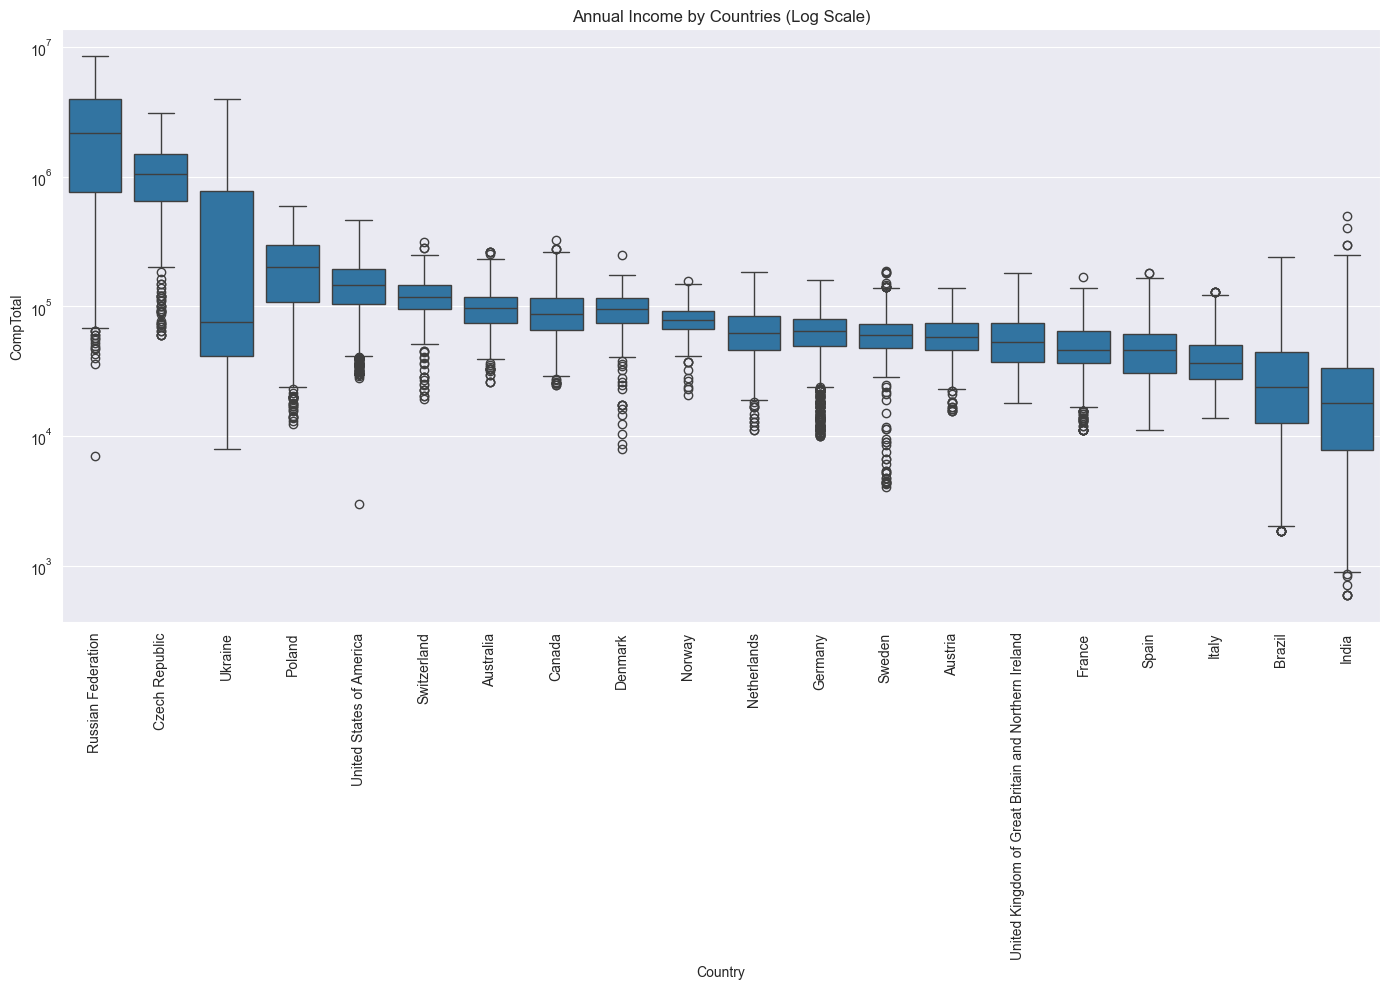

In [90]:
# generate a feature column base on YearsCodePro to indicate seniority level
df['seniority'] = pd.cut(df['YearsCodePro'].fillna(0), bins=[-0.1,1,3,7,15,50], labels=['Intern/Junior','Junior','Mid','Senior','Principal'])
WaitForOneHotEncoder.append('seniority')
# select top 20 countries which have the most data points
top_countries = df['Country'].value_counts().nlargest(20).index.tolist()

# plot boxplot of CompTotal by Country in log scale, only for top 20 countries
plt.figure(figsize=(14,10))
_tmp_df = df[df.Country.isin(top_countries)].copy()
order = _tmp_df.groupby('Country')['CompTotal'].mean().sort_values(ascending=False).index
sns.boxplot(x='Country', y='CompTotal', data=_tmp_df, order=order,log_scale=True)
plt.xticks(rotation=90)
plt.title('Annual Income by Countries (Log Scale)')
plt.tight_layout()
plt.show()


In [91]:
# get rid of outliers in CompTotal, base on the boxplot
for country in df.Country.unique():
    log_comp = df[df.Country==country]['CompTotal'].apply(lambda x: np.log1p(x))
    Q1 = log_comp.quantile(0.25)
    Q3 = log_comp.quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = log_comp[(log_comp < lower_bound) | (log_comp > upper_bound)]
    print(f'{country} start to remove outliers')
    print(f"Q1={Q1}, Q3={Q3}, IQR={IQR}")
    print(f"Lower bound={lower_bound}, Upper bound={upper_bound}")
    print(f"Outliers count={len(outliers)}")
    print('-'*40)
    # df = df.loc[(df['CompTotal'] >= 1000) & (df['CompTotal'] <= 500000)]
    # print(df[['CompTotal']].describe())
    # remove data using the outlier bounds' index
    df = df.loc[~df.index.isin(outliers.index)]
df.reset_index(inplace=True,drop=True)

Pakistan start to remove outliers
Q1=12.872882266616799, Q3=15.096444681204078, IQR=2.2235624145872794
Lower bound=9.537538644735879, Upper bound=18.431788303084996
Outliers count=1
----------------------------------------
Austria start to remove outliers
Q1=10.740988743751851, Q3=11.21408984639664, IQR=0.47310110264478844
Lower bound=10.031337089784667, Upper bound=11.923741500363821
Outliers count=14
----------------------------------------
Turkey start to remove outliers
Q1=11.407576060361786, Q3=13.915326269176326, IQR=2.5077502088145405
Lower bound=7.645950747139975, Upper bound=17.676951582398136
Outliers count=0
----------------------------------------
France start to remove outliers
Q1=10.51785060230594, Q3=11.077454797630603, IQR=0.5596041953246633
Lower bound=9.678444309318945, Upper bound=11.916861090617598
Outliers count=31
----------------------------------------
United States of America start to remove outliers
Q1=11.561725152903833, Q3=12.17998955306044, IQR=0.6182644001

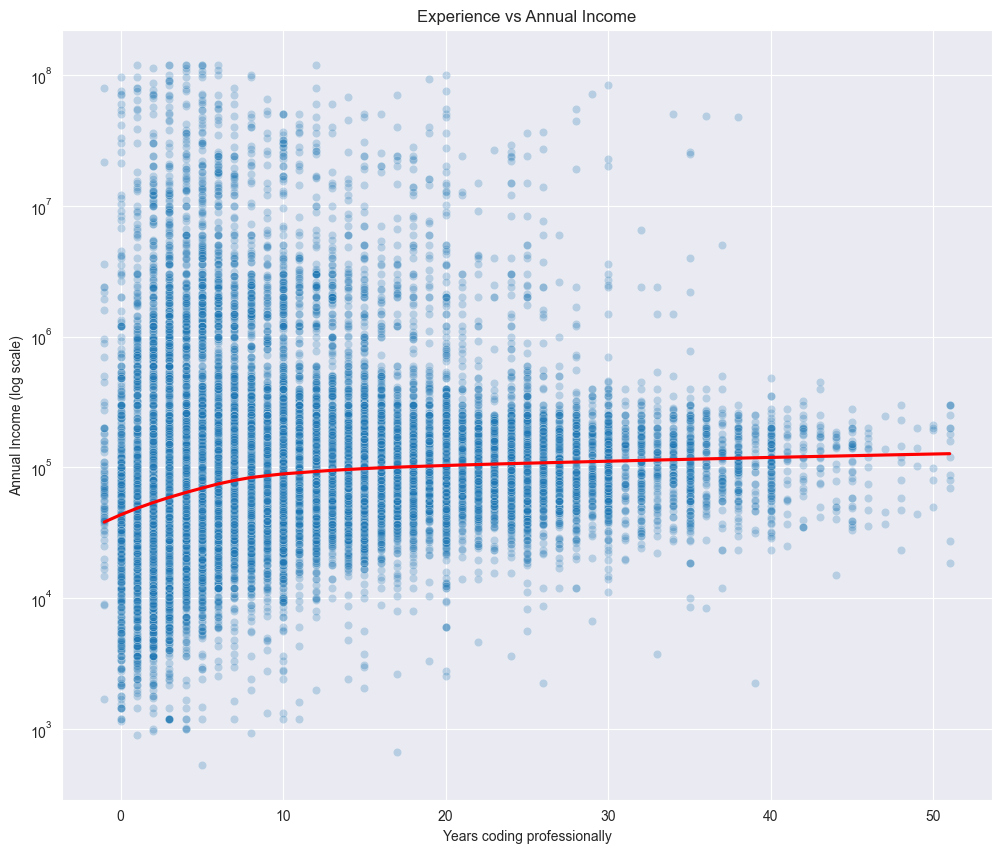

In [92]:
# check correlation between YearsCodePro and CompTotal
plt.figure(figsize=(12,10))
ax1 = sns.scatterplot(x='YearsCodePro', y='CompTotal', data=df, alpha=0.25)
ax2 = sns.regplot(x='YearsCodePro', y='CompTotal', data=df, scatter=False, lowess=True, color='red')
ax1.set_yscale('log')
ax2.set_yscale('log')
plt.xlabel('Years coding professionally')
plt.ylabel('Annual Income (log scale)')
plt.title('Experience vs Annual Income')
plt.show()


In [93]:
# Interactive choropleth: median compensation by country (log scale)
import numpy as np
_tmp_df = df.copy()
_tmp_df['logComp'] = np.log1p(df['CompTotal'])
country_median = _tmp_df.groupby('Country', as_index=False)['logComp'].median()
fig = px.choropleth(country_median, locations='Country', locationmode='country names',
                    color='logComp', hover_name='Country',
                    color_continuous_scale='thermal', title='Mean Annual Income by Country')
fig.update_layout(height=500)
fig.show()

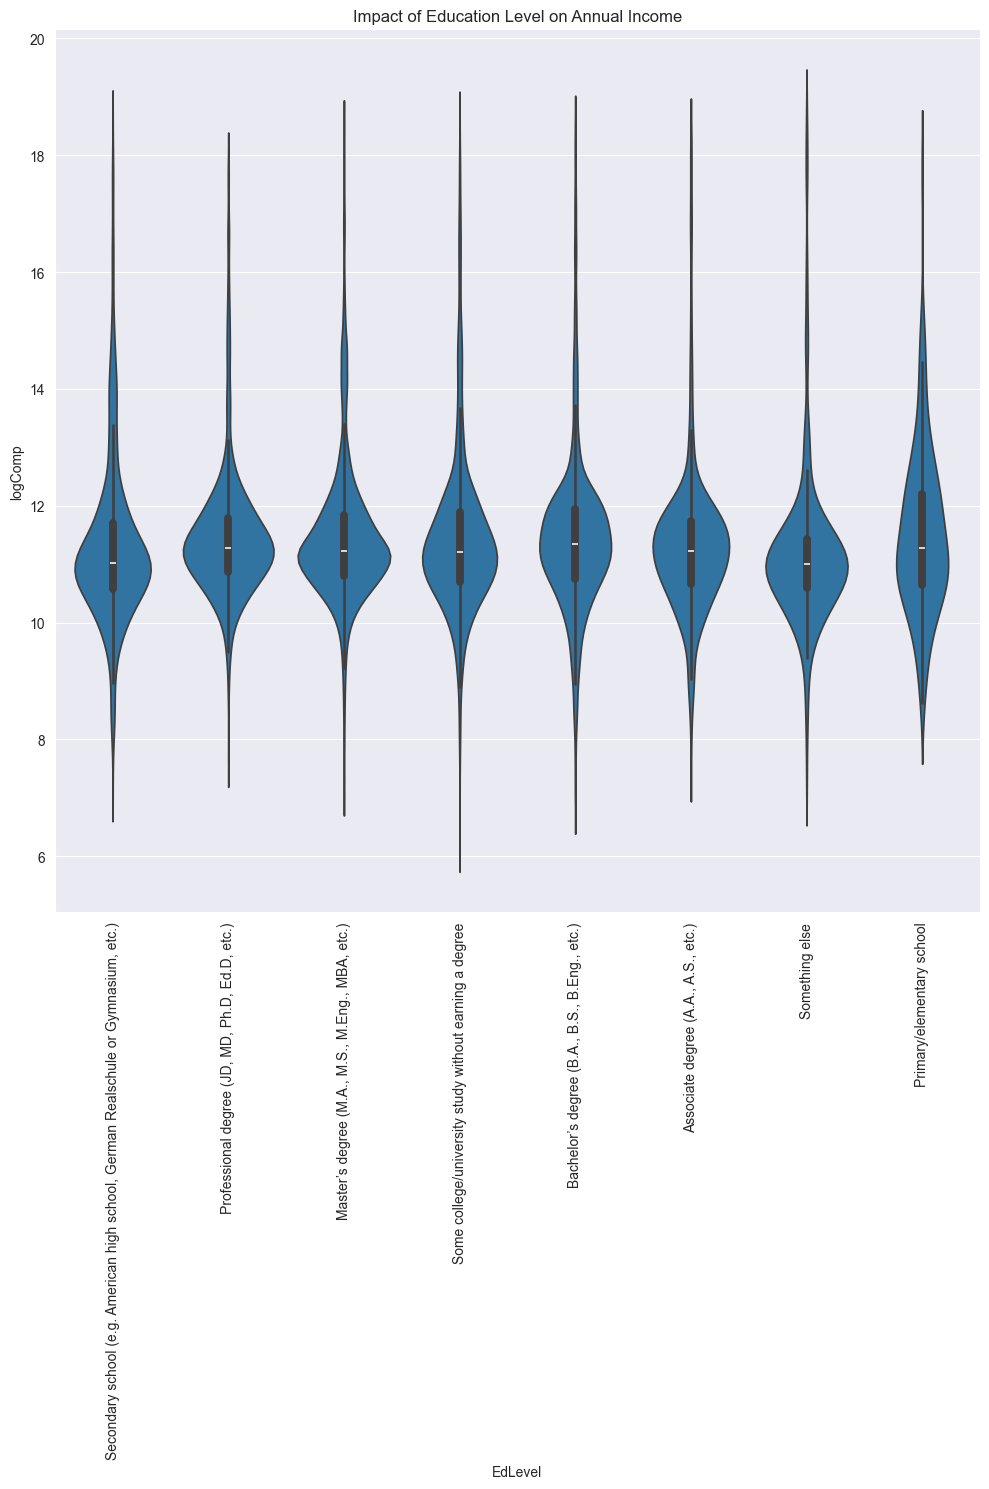

Professional degree (JD, MD, Ph.D, Ed.D, etc.) start to remove outliers
Q1=10.836419620144527, Q3=11.695255355062795, IQR=0.8588357349182676
Lower bound=9.548166017767127, Upper bound=12.983508957440197
Outliers count=12
----------------------------------------
Master’s degree (M.A., M.S., M.Eng., MBA, etc.) start to remove outliers
Q1=10.775105508515772, Q3=11.686715132419568, IQR=0.9116096239037965
Lower bound=9.407691072660077, Upper bound=13.054129568275263
Outliers count=135
----------------------------------------
Some college/university study without earning a degree start to remove outliers
Q1=10.666222516210075, Q3=11.695255355062795, IQR=1.0290328388527197
Lower bound=9.122673257930995, Upper bound=13.238804613341873
Outliers count=62
----------------------------------------
Bachelor’s degree (B.A., B.S., B.Eng., etc.) start to remove outliers
Q1=10.746791002125589, Q3=11.849404844423074, IQR=1.102613842297485
Lower bound=9.09287023867936, Upper bound=13.5033256078693
Outlier

In [121]:
# check the impact of education level on salary
plt.figure(figsize=(10, 15))
sns.violinplot(data=_tmp_df, x='EdLevel', y='logComp')
plt.title('Impact of Education Level on Annual Income')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# so by ed level, there are some outliners, we need to remove them
for edlevel in df.EdLevel.unique():
    log_comp = df[df.EdLevel==edlevel]['CompTotal'].apply(lambda x: np.log1p(x))
    Q1 = log_comp.quantile(0.25)
    Q3 = log_comp.quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = log_comp[(log_comp < lower_bound) | (log_comp > upper_bound)]
    print(f'{edlevel} start to remove outliers')
    print(f"Q1={Q1}, Q3={Q3}, IQR={IQR}")
    print(f"Lower bound={lower_bound}, Upper bound={upper_bound}")
    print(f"Outliers count={len(outliers)}")
    print('-'*40)
    # df = df.loc[(df['CompTotal'] >= 1000) & (df['CompTotal'] <= 500000)]
    # print(df[['CompTotal']].describe())
    # remove data using the outlier bounds' index
    df = df.loc[~df.index.isin(outliers.index)]
df.reset_index(inplace=True,drop=True)

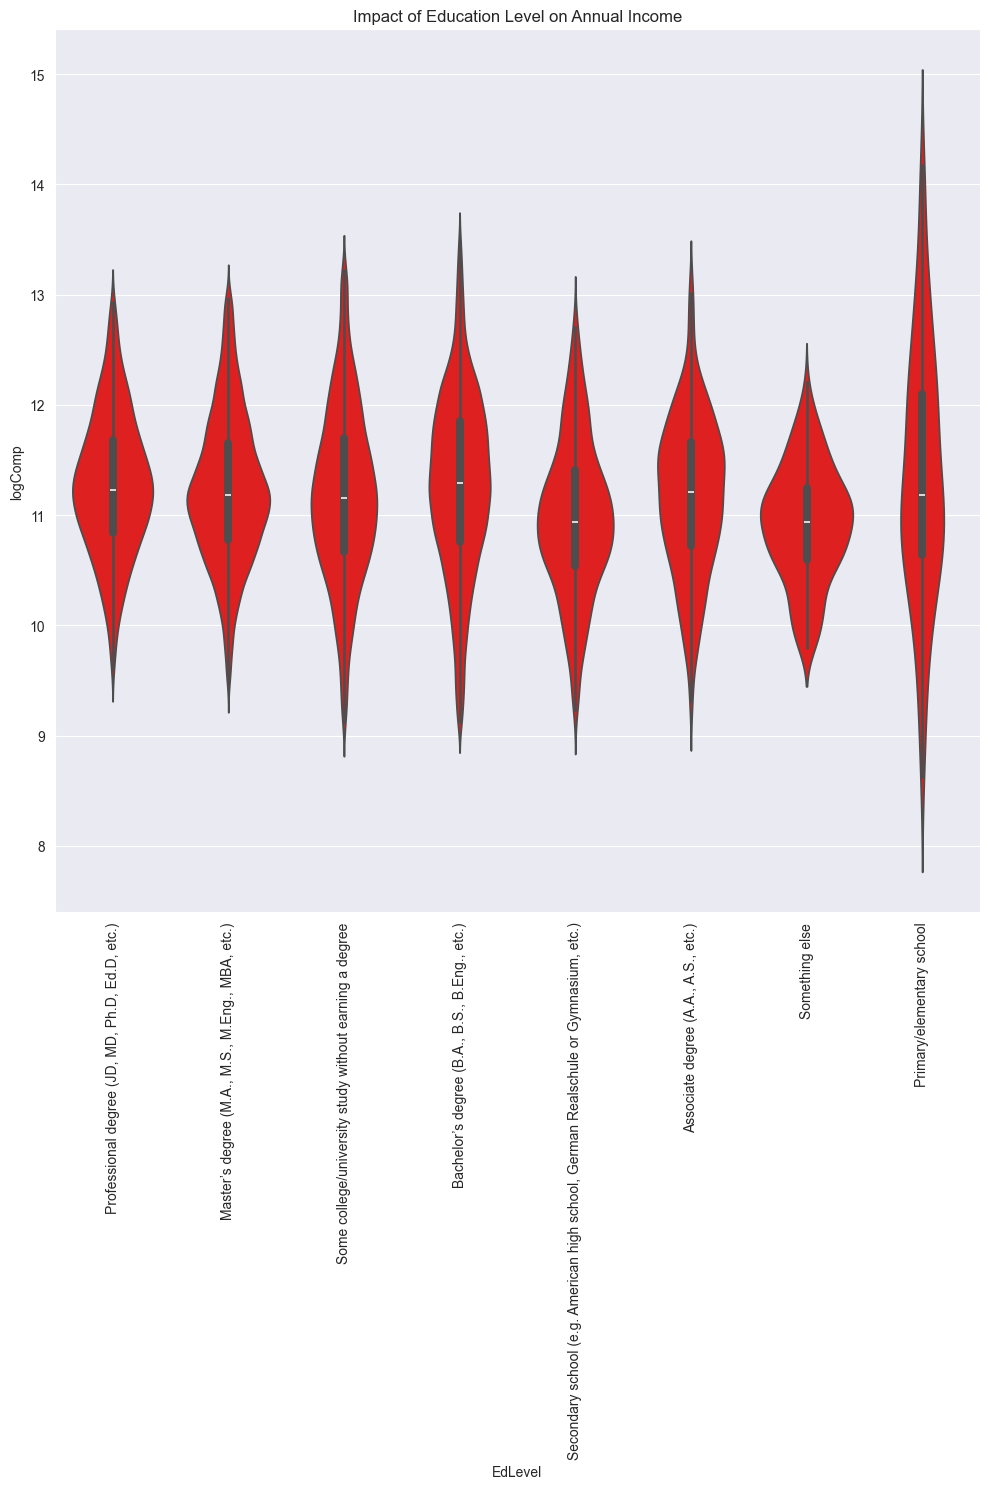

In [126]:
# check the impact of education level on salary
plt.figure(figsize=(10, 15))
_tmp_df = df.copy()
_tmp_df['logComp'] = np.log1p(df['CompTotal'])
sns.violinplot(data=_tmp_df, x='EdLevel', y='logComp', color='red')
plt.title('Impact of Education Level on Annual Income')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [94]:
basic_info('JobSatPoints_1')
# JobSatPoints_1~11 need to fillna

# it is an over all job satisfaction score from 1 to 100. total score should be 100 lets check
# !! there is no jsp_2 and jsp_3
# fillna with -1 first
for i in range(1, 12):
    if i in [2,3]:
        continue
    df[f'JobSatPoints_{i}'] = df[f'JobSatPoints_{i}'].fillna(-1)

total_score = df[[f'JobSatPoints_{i}' for i in range(1, 12) if i not in [2,3]]].sum(axis=1)
print(total_score.value_counts())
# ok there are some value larger than 100, let's check total number
print((total_score > 100).sum())
# let try to normalize these values to 100, reverse the mistake, round to integer incase accuracy problem
df.loc[total_score > 100, [f'JobSatPoints_{i}' for i in range(1, 12) if i not in [2,3]]] = df.loc[total_score > 100, [f'JobSatPoints_{i}' for i in range(1, 12) if i not in [2,3]]].div(total_score[total_score > 100], axis=0).multiply(100)
df[[f'JobSatPoints_{i}' for i in range(1, 12) if i not in [2,3]]] = df[[f'JobSatPoints_{i}' for i in range(1, 12) if i not in [2,3]]].round().astype(int)








0    90.0
1     NaN
2     0.0
3     NaN
4    10.0
Name: JobSatPoints_1, dtype: float64
----------------------------------------
30563   NaN
30564   NaN
30565   NaN
30566   NaN
30567   NaN
Name: JobSatPoints_1, dtype: float64
----------------------------------------
10036
----------------------------------------
JobSatPoints_1
0.0     7352
10.0    3048
20.0    2265
5.0     1146
30.0     985
        ... 
96.0       1
83.0       1
7.5        1
27.0       1
37.0       1
Name: count, Length: 81, dtype: int64
----------------------------------------
****************************************
 100.0    13217
-9.0       9933
 0.0       3055
 99.0       141
 90.0        95
          ...  
 592.0        1
 358.0        1
 608.0        1
 532.0        1
 271.0        1
Name: count, Length: 452, dtype: int64
2986


In [95]:
total_score = df[[f'JobSatPoints_{i}' for i in range(1, 12) if i not in [2,3]]].sum(axis=1)
print(total_score.value_counts())
# ok there are some value larger than 100, let's check total number
print((total_score > 100).sum())

 100    14336
-9       9933
 0       3055
 99       855
 101      619
        ...  
 6          1
-6          1
 32         1
 88         1
 23         1
Name: count, Length: 111, dtype: int64
872


In [96]:
# check null values again
null_counts = df.isnull().sum()
print(null_counts[null_counts > 0])

TechEndorse               1718
OpSysPersonal use          573
OpSysProfessional use     2100
TBranch                   1513
SurveyLength              1070
SurveyEase                1030
ConvertedCompYearly       9276
JobSat                   10049
seniority                  100
dtype: int64


In [97]:
drop_columns = ['TechEndorse','SurveyLength','SurveyEase','ConvertedCompYearly']
explode_columns = ['OpSysPersonal use','OpSysProfessional use']
for col in explode_columns:
    df = fast_explode(df,target_column=col, fillna='', split=';', prefix=f'{col} ')
df.drop(columns=drop_columns, inplace=True)

df['TBranch'] = df['TBranch'].map({'Yes': 1, 'No': 0})
df['TBranch'] = df['TBranch'].fillna(-1)

WaitForOneHotEncoder.append('Country')
WaitForOneHotEncoder.append('Currency')



OpSysPersonal use 29995 30568
OpSysProfessional use 28468 30568


In [98]:
null_counts = df.isnull().sum()
print(null_counts[null_counts > 0])
df
#TODO drop seniority?

JobSat       10049
seniority      100
dtype: int64


,MainBranch,Age,Employment,RemoteWork,EdLevel,YearsCode,YearsCodePro,DevType,OrgSize,PurchaseInfluence,...,OpSysProfessional use MacOS,OpSysProfessional use Other (please specify):,OpSysProfessional use Other Linux-based,OpSysProfessional use Red Hat,OpSysProfessional use Solaris,OpSysProfessional use Ubuntu,OpSysProfessional use Windows,OpSysProfessional use Windows Subsystem for Linux (WSL),OpSysProfessional use iOS,OpSysProfessional use iPadOS
0,I am a developer by profession,18-24 years old,"Employed, full-time;Student, full-time;Indepen...","Hybrid (some remote, some in-person)","Secondary school (e.g. American high school, G...",3,1,Data scientist or machine learning specialist,100 to 499 employees,I have some influence,...,False,False,False,False,False,False,False,False,False,False
1,"I am not primarily a developer, but I write co...",25-34 years old,"Employed, full-time","Hybrid (some remote, some in-person)","Professional degree (JD, MD, Ph.D, Ed.D, etc.)",12,6,Academic researcher,100 to 499 employees,I have little or no influence,...,False,False,False,False,False,True,True,False,False,False
2,I am a developer by profession,35-44 years old,"Employed, full-time",Remote,"Master’s degree (M.A., M.S., M.Eng., MBA, etc.)",15,6,Data scientist or machine learning specialist,20 to 99 employees,I have a great deal of influence,...,True,False,False,False,False,False,False,False,False,False
3,I am a developer by profession,35-44 years old,"Independent contractor, freelancer, or self-em...",Remote,"Master’s degree (M.A., M.S., M.Eng., MBA, etc.)",27,17,"Developer, back-end","Just me - I am a freelancer, sole proprietor, ...",I have a great deal of influence,...,True,False,False,False,False,False,False,False,False,False
4,I am a developer by profession,25-34 years old,"Employed, full-time;Student, part-time",Remote,Some college/university study without earning ...,7,7,Student,10 to 19 employees,I have some influence,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30563,I am a developer by profession,18-24 years old,"Employed, full-time;Independent contractor, fr...","Hybrid (some remote, some in-person)","Secondary school (e.g. American high school, G...",3,3,"Developer, full-stack","1,000 to 4,999 employees",I have little or no influence,...,False,False,False,False,False,False,False,False,False,False
30564,I am a developer by profession,25-34 years old,"Employed, full-time","Hybrid (some remote, some in-person)","Bachelor’s degree (B.A., B.S., B.Eng., etc.)",10,7,"Developer, full-stack",20 to 99 employees,I have a great deal of influence,...,False,False,True,False,False,False,True,False,False,False
30565,I am a developer by profession,25-34 years old,"Employed, full-time","Hybrid (some remote, some in-person)","Master’s degree (M.A., M.S., M.Eng., MBA, etc.)",13,9,"Developer, full-stack",100 to 499 employees,I have little or no influence,...,False,False,False,False,False,False,False,False,False,False
30566,I am a developer by profession,35-44 years old,"Employed, full-time",Remote,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",20,18,"Developer, back-end",100 to 499 employees,I have little or no influence,...,True,False,False,False,False,False,False,False,False,False


In [99]:
# replace all boolean values to 1 and 0
df.replace({True: 1, False: 0}, inplace=True)
# df

In [100]:
for train_df in df.groupby(['Country', 'Currency']):
    print(train_df[0], train_df[1].shape)

('Afghanistan', 'AFN') (7, 478)
('Albania', 'AED') (1, 478)
('Albania', 'ALL') (7, 478)
('Albania', 'EUR') (4, 478)
('Albania', 'USD') (1, 478)
('Algeria', 'DZD') (9, 478)
('Andorra', 'EUR') (3, 478)
('Angola', 'AOA') (1, 478)
('Antigua and Barbuda', 'AUD') (1, 478)
('Argentina', 'ARS') (70, 478)
('Argentina', 'GBP') (1, 478)
('Argentina', 'PLN') (1, 478)
('Argentina', 'USD') (103, 478)
('Armenia', 'AMD') (20, 478)
('Armenia', 'USD') (3, 478)
('Australia', 'AUD') (697, 478)
('Australia', 'USD') (1, 478)
('Austria', 'EUR') (457, 478)
('Austria', 'GEL') (1, 478)
('Azerbaijan', 'AZN') (7, 478)
('Azerbaijan', 'USD') (1, 478)
('Bahrain', 'BHD') (1, 478)
('Bangladesh', 'BDT') (131, 478)
('Bangladesh', 'USD') (1, 478)
('Belarus', 'BYN') (10, 478)
('Belarus', 'USD') (20, 478)
('Belgium', 'EUR') (294, 478)
('Benin', 'XOF') (1, 478)
('Bhutan', 'INR') (1, 478)
('Bolivia', 'BOB') (11, 478)
('Bolivia', 'USD') (5, 478)
('Bosnia and Herzegovina', 'BAM') (17, 478)
('Bosnia and Herzegovina', 'EUR') (4,

# we can see that some country and currency have very few data, we can filter out these data and only keep the country and currency with more than 1000 data points.


In [101]:
# finding the country and currency with more than 1000 data points
for (country,currency),train_df in df.groupby(['Country', 'Currency']):
    if train_df.shape[0]>1000:
        print(country,currency)


Canada CAD
France EUR
Germany EUR
India INR
United Kingdom of Great Britain and Northern Ireland GBP
United States of America USD


In [102]:
# check comp total distribution in these countries, in log scale
import plotly.express as px
for (country,currency), train_df in df.groupby(['Country', 'Currency']):
    if train_df.shape[0]>1000:
        print(train_df.shape)
        fig = px.histogram(
            train_df,
            x='CompTotal',
            nbins=100,  # Adjust bins for granularity
            title=f'Salary Distribution Histogram ({country}, {currency})',
            labels={'CompTotal': 'Salary Amount', 'Count': 'Number of People'},
            log_y=True  # Log scale for better visibility
        )

        fig.show()

(1187, 478)


(1229, 478)


(2656, 478)


(1415, 478)


(1913, 478)


(6659, 478)


# We are now cleaned the data, and ready for machine learning model training.
# Because the salary is in different currency, and the salary distribution is very different in different country, we will train a model for each country-currency group that has more than 1000 data points.
# We are going to test several regression models which is often used in Kaggle competitions, and a baseline dummy regressor.


AI generated code for regression model training and evaluation

In [103]:
# ====== 0. Imports ======
from sklearn.ensemble import (
    GradientBoostingRegressor,
    RandomForestRegressor,
    HistGradientBoostingRegressor,
)
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, HuberRegressor
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold, cross_validate, train_test_split
from sklearn.inspection import permutation_importance
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np
import pandas as pd


# df_cleaned = df.loc[df["CompTotal"] >= 1000].copy()
df_cleaned.dropna(inplace=True)

# ====== 1.helper: wrap a regressor with log-target transform ======
def make_log_model(reg):
    return TransformedTargetRegressor(
        regressor=reg,
        func=np.log1p,          # y -> log(1+y)
        inverse_func=np.expm1   # yhat_log -> exp(yhat_log)-1  (metrics in original units)
    )
country_result = {}
# ====== 2. Loop over each Country-Currency group ======
for (country, currency), train_df in df_cleaned.groupby(["Country", "Currency"]):
    if train_df.shape[0] < 1000:
        # print(f"Skipping group ({country}, {currency}) — too few rows ({train_df.shape[0]})")
        continue

    print(country, 'data is being processed')

    # Split features and target
    X = train_df.drop(columns=["CompTotal"])
    y = train_df["CompTotal"]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    # Identify numeric & categorical columns, we will feed them into preprocessor
    num_cols = X_train.select_dtypes(include=["number"]).columns.tolist()
    cat_cols = WaitForOneHotEncoder

    # Preprocessing, here is the reason we marked some columns for one-hot encoding earlier
    preprocessor = ColumnTransformer(
        transformers=[
            ("num", Pipeline([("scaler", StandardScaler())]), num_cols),
            ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), cat_cols),
        ],
        remainder="drop",
        verbose_feature_names_out=False,
    )

    # ====== 3. Define regression models (all wrapped with log-target) ======
    models = {
        "GradientBoostingRegressor": make_log_model(GradientBoostingRegressor(
            n_estimators=300, learning_rate=0.05, max_depth=3, random_state=42
        )),
        "RandomForestRegressor": make_log_model(RandomForestRegressor(
            n_estimators=600, random_state=42, n_jobs=-1
        )),
        "HistGradientBoostingRegressor": make_log_model(HistGradientBoostingRegressor(
            learning_rate=0.05, max_depth=None, random_state=42
        )),
        "XGBRegressor": make_log_model(XGBRegressor(
            n_estimators=800, learning_rate=0.05, max_depth=6,
            subsample=0.8, colsample_bytree=0.8,
            n_jobs=-1, random_state=42, objective="reg:squarederror"
        )),
        "LGBMRegressor": make_log_model(LGBMRegressor(
            n_estimators=800, learning_rate=0.05, num_leaves=31,
            subsample=0.8, colsample_bytree=0.8,
            random_state=42, objective="rmse", n_jobs=-1
        )),
        "LinearRegression": make_log_model(LinearRegression()),
        "Ridge": make_log_model(Ridge(alpha=1.0, random_state=42)),
        "Lasso": make_log_model(Lasso(alpha=0.001, max_iter=5000, random_state=42)),
        "HuberRegressor": make_log_model(HuberRegressor(max_iter=2000)),
        "DummyMedian": make_log_model(DummyRegressor(strategy="median")),
    }

    # ====== 4. Cross-validation config (metrics now in ORIGINAL salary units) ======
    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    scoring = {
        "r2": "r2",
        "neg_mae": "neg_mean_absolute_error",
        "neg_mse": "neg_mean_squared_error",
    }

    rows = []
    for name, model in models.items():
        # define a pipeline with preprocessor + model
        pipe = Pipeline(steps=[("preprocessor", preprocessor), ("model", model)])
        # cross-validate
        cvres = cross_validate(
            pipe, X_train, y_train,
            scoring=scoring, cv=cv, n_jobs=-1, error_score="raise"
        )

        r2 = np.mean(cvres["test_r2"]) # r2, total variance explained
        mae = -np.mean(cvres["test_neg_mae"]) # mae, mean absolute error
        rmse = np.sqrt(-np.mean(cvres["test_neg_mse"])) # rmse, root mean squared error

        rows.append({
            "Model": name,
            "CV_R2": r2,
            "CV_MAE": mae,
            "CV_RMSE": rmse,
        })
        print(f"{name:>28s} | R2={r2: .3f} | MAE={mae: .0f} | RMSE={rmse: .0f}")

    results_df = pd.DataFrame(rows).sort_values("CV_R2", ascending=False)
    best_model_name = results_df.iloc[0]["Model"]
    print(f"\nBest model (by CV R²) in ({country}, {currency}): {best_model_name}")
    print(results_df.head(5))
    country_result[country] = {'best_model': best_model_name, 'results_df': results_df}
    # ====== 5. Fit best model on train; evaluate on test ======
    best_model = models[best_model_name]
    best_pipeline = Pipeline(steps=[("preprocessor", preprocessor), ("model", best_model)])
    best_pipeline.fit(X_train, y_train)

    # Predict in ORIGINAL units (TransformedTargetRegressor handles log inverse automatically)
    y_pred = best_pipeline.predict(X_test)

    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = float(np.sqrt(mse))

    print(f"\n--- Test Performance ({best_model_name}) [{country}, {currency}] ---")
    print(f"R²    : {r2:.3f}")
    print(f"MAE   : {mae:,.0f}")
    print(f"RMSE  : {rmse:,.0f}")

    # ====== 6. Feature importance (tree models) or permutation importance ======
    try:
        # In our pipeline, 'model' is TransformedTargetRegressor.
        # Access the underlying fitted regressor via .regressor_
        final_ttr = best_pipeline.named_steps["model"]
        final_model = getattr(final_ttr, "regressor_", final_ttr)  # fallback if not TTR

        if hasattr(final_model, "feature_importances_"):
            try:
                feature_names = best_pipeline.named_steps["preprocessor"].get_feature_names_out()
            except Exception:
                feature_names = [f"f{i}" for i in range(len(final_model.feature_importances_))]
            importances = final_model.feature_importances_
            top_idx = np.argsort(importances)[::-1][:30]
            print("\nTop 30 features (model importances):")
            for i in top_idx:
                print(f"{feature_names[i]:40s} {importances[i]:.6f}")
        else:
            # Permutation importance on the WHOLE pipeline (preds already in original units)
            r = permutation_importance(
                best_pipeline, X_test, y_test,
                n_repeats=5, n_jobs=-1, random_state=42, scoring="r2"
            )
            try:
                feature_names = best_pipeline.named_steps["preprocessor"].get_feature_names_out()
            except Exception:
                feature_names = [f"f{i}" for i in range(r.importances_mean.shape[0])]
            idx = np.argsort(r.importances_mean)[::-1][:30]
            print("\nTop 30 features (permutation importance):")
            for i in idx:
                print(f"{feature_names[i]:40s} {r.importances_mean[i]:.6f}")
    except Exception as e:
        print("\n[Feature importance skipped]", e)
# storage the country result to csv
country_result_df = pd.DataFrame(country_result)
country_result_df.to_csv('country_model_results.csv',index=False)

Germany data is being processed
   GradientBoostingRegressor | R2= 0.416 | MAE= 12113 | RMSE= 16838
       RandomForestRegressor | R2= 0.371 | MAE= 12705 | RMSE= 17473
HistGradientBoostingRegressor | R2= 0.419 | MAE= 12277 | RMSE= 16791
                XGBRegressor | R2= 0.424 | MAE= 12120 | RMSE= 16726
               LGBMRegressor | R2= 0.433 | MAE= 12159 | RMSE= 16563
            LinearRegression | R2=-2775.375 | MAE= 163532 | RMSE= 1166217
                       Ridge | R2=-0.196 | MAE= 18152 | RMSE= 23977
                       Lasso | R2= 0.263 | MAE= 13811 | RMSE= 18892
              HuberRegressor | R2=-1.163 | MAE= 23774 | RMSE= 32318
                 DummyMedian | R2=-0.018 | MAE= 16961 | RMSE= 22225

Best model (by CV R²) in (Germany, EUR): LGBMRegressor
                           Model     CV_R2        CV_MAE       CV_RMSE
4                  LGBMRegressor  0.433067  12159.283481  16562.639821
3                   XGBRegressor  0.424112  12120.468804  16725.985915
2  HistGradi

AI genarated explanation of regression metrics


### 🧮 **1️⃣ R² — Coefficient of Determination**


**Interpretation:**
- Measures how much of the variance in the target (salary) your model can explain.
- **R² = 1.0** → perfect prediction
- **R² = 0.0** → model predicts no better than the mean
- **R² < 0.0** → worse than predicting the mean

➡️ Example:
`R² = 0.44` → the model explains **44% of salary variation** in the data.

---

### 💵 **2️⃣ MAE — Mean Absolute Error**


**Interpretation:**
- The **average absolute difference** between predicted and actual salaries.
- Easy to read — same unit as the target (USD, DKK, etc.).
- **Lower = better.**

➡️ Example:
`MAE = 38,851` → predictions are off by about **\$38k on average**.

---

### 📈 **3️⃣ RMSE — Root Mean Squared Error**


**Interpretation:**
- Like MAE, but **penalizes large errors more heavily** because it squares them.
- Good indicator of how big errors can get in extreme cases.
- **Lower = better.**

➡️ Example:
`RMSE = 57,113` → the **typical deviation** between predictions and actual salaries is about **\$57k**.

---

### 📘 **Comparison Table**

| Metric | Unit | Penalizes Large Errors? | Interpretation | Best Value |
|:-------|:------|:------------------------|:---------------|:------------|
| **R²** | None | ❌ | % of explained variance | **1.0** |
| **MAE** | Same as target | ❌ | Average absolute error | **0** |
| **RMSE** | Same as target | ✅ | Typical weighted error (sensitive to outliers) | **0** |

---

### ✅ **Summary Example (from your model)**

| Metric | Value | Meaning |
|:--------|:--------|:---------|
| **R²** | 0.44 | Model explains 44% of salary variation |
| **MAE** | 38,851 | Average prediction error ≈ \$38k |
| **RMSE** | 57,113 | Typical deviation ≈ \$57k (due to outliers) |

---

**In short:**
> LightGBM model explains about **44%** of salary variance,
> predicts within **\$39k** on average,
> and its larger misses are around **\$57k** —
> which is strong performance for a noisy, real-world salary dataset.

In [108]:
# =========================
# USA-only salary regression — LightGBM + Optuna fine-tune
# =========================
# pip install optuna
import optuna
from lightgbm import LGBMRegressor
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, KFold, cross_validate
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

# =====================================
# 0) Filter to USA (and USD if desired)
# =====================================
# df must already exist.
# get rid of column contain JobSat
df = df[[c for c in df.columns if "JobSat" not in c]].copy()
usa = df[(df["Country"] == "United States of America") & (df["Currency"] == "USD")].copy()
# If you don't want to filter currency, use: usa = df[df["Country"] == "United States of America"].copy()
usa = usa[usa["CompTotal"] >= 1000].dropna()

print(f"USA rows: {len(usa)}")

# ================
# 1) Train/test split
# ================
X = usa.drop(columns=["CompTotal"])
y = usa["CompTotal"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# ======================================
# 2) Preprocessing (numeric + categorical)
# ======================================
num_cols = X_train.select_dtypes(include=["number"]).columns.tolist()
cat_cols = X_train.select_dtypes(exclude=["number"]).columns.tolist()

try:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
except TypeError:  # older scikit-learn
    ohe = OneHotEncoder(handle_unknown="ignore", sparse=False)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", Pipeline([("scaler", StandardScaler())]), num_cols),
        ("cat", ohe, cat_cols),
    ],
    remainder="drop",
    verbose_feature_names_out=False,
)

# ===========================
# 3) Log-target wrapper
# ===========================
def make_log(reg):
    return TransformedTargetRegressor(
        regressor=reg, func=np.log1p, inverse_func=np.expm1
    )

# ===========================
# 4) Baseline LGBM pipeline
# ===========================
def make_pipeline(lgbm_params: dict):
    reg = LGBMRegressor(
        random_state=42,
        n_jobs=-1,
        **lgbm_params
    )
    pipe = Pipeline([
        ("preprocessor", preprocessor),
        ("model", make_log(reg)),
    ])
    return pipe

# ===========================
# 5) Optuna objective
# ===========================
cv = KFold(n_splits=5, shuffle=True, random_state=42)
SCORING = {"r2":"r2", "neg_mae":"neg_mean_absolute_error", "neg_mse":"neg_mean_squared_error"}

def objective(trial: optuna.Trial) -> float:
    # Search space (mirrors your RandomizedSearchCV grid, plus a bit extra)
    params = {
        "objective": "regression",
        "n_estimators": trial.suggest_int("n_estimators", 600, 1500, step=100),
        "learning_rate": trial.suggest_float("learning_rate", 0.02, 0.10, log=True),
        "num_leaves": trial.suggest_categorical("num_leaves", [31, 63, 127, 255]),
        "max_depth": trial.suggest_categorical("max_depth", [-1, 10, 15, 20]),
        "min_child_samples": trial.suggest_categorical("min_child_samples", [20, 50, 100, 200]),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
        "reg_lambda": trial.suggest_float("reg_lambda", 0.0, 3.0),
        "reg_alpha": trial.suggest_float("reg_alpha", 0.0, 3.0),
    }

    pipe = make_pipeline(params)

    # Cross-validated R^2 on training split (maximize)
    cvres = cross_validate(pipe, X_train, y_train, scoring=SCORING, cv=cv, n_jobs=-1)
    mean_r2 = float(np.mean(cvres["test_r2"]))

    # Optional: report intermediate values to Optuna
    trial.report(mean_r2, step=0)

    return mean_r2

# ===========================
# 6) Run study
# ===========================
study = optuna.create_study(direction="maximize", study_name="lgbm_salary_usa")


study.optimize(objective, n_trials=50, show_progress_bar=True)

print("\n[USA] Best trial:", study.best_trial.number)
print("[USA] Best R² (CV):", round(study.best_value, 4))
print("[USA] Best params:")
for k, v in study.best_params.items():
    print(f"  {k}: {v}")

# ===========================
# 7) Fit best pipeline on train and evaluate on test
# ===========================
best_params = study.best_params.copy()
best_params["objective"] = "regression"  # ensure objective is set

best_pipeline = make_pipeline(best_params)
best_pipeline.fit(X_train, y_train)

# Test evaluation
y_pred = best_pipeline.predict(X_test)
r2   = r2_score(y_test, y_pred)
mae  = mean_absolute_error(y_test, y_pred)
rmse = float(np.sqrt(mean_squared_error(y_test, y_pred)))

print(f"\n--- Test Performance (LGBMRegressor[OPTUNA_USA]) [USA, USD] ---")
print(f"R²    : {r2:.3f}")
print(f"MAE   : {mae:,.0f}")
print(f"RMSE  : {rmse:,.0f}")

# ===========================
# 8) Feature importances (top 30)
# ===========================
try:
    final_ttr = best_pipeline.named_steps["model"]
    final_model = getattr(final_ttr, "regressor_", final_ttr)

    if hasattr(final_model, "feature_importances_"):
        try:
            feature_names = best_pipeline.named_steps["preprocessor"].get_feature_names_out()
        except Exception:
            feature_names = [f"f{i}" for i in range(len(final_model.feature_importances_))]
        importances = final_model.feature_importances_
        top_idx = np.argsort(importances)[::-1][:30]
        print("\nTop 30 features (model importances):")
        for i in top_idx:
            print(f"{feature_names[i]:40s} {importances[i]:.6f}")
    else:
        # Fallback: permutation importance (slower)
        from sklearn.inspection import permutation_importance
        r = permutation_importance(
            best_pipeline, X_test, y_test,
            n_repeats=5, n_jobs=-1, random_state=42, scoring="r2"
        )
        try:
            feature_names = best_pipeline.named_steps["preprocessor"].get_feature_names_out()
        except Exception:
            feature_names = [f"f{i}" for i in range(r.importances_mean.shape[0])]
        idx = np.argsort(r.importances_mean)[::-1][:30]
        print("\nTop 30 features (permutation importance):")
        for i in idx:
            print(f"{feature_names[i]:40s} {r.importances_mean[i]:.6f}")
except Exception as e:
    print("\n[Feature importance skipped]", e)

# ===========================
# 9) Optional: Save Optuna artifacts
# ===========================
# optuna.importance.get_param_importances(study)  # to inspect param influence
# study.trials_dataframe().to_csv("optuna_lgbm_trials.csv", index=False)

"\n[USA] Best params: {'model__regressor__subsample': 0.8, 'model__regressor__reg_lambda': 0.1, 'model__regressor__reg_alpha': 0.1, 'model__regressor__objective': 'regression', 'model__regressor__num_leaves': 63, 'model__regressor__n_estimators': 600, 'model__regressor__min_child_samples': 20, 'model__regressor__max_depth': 10, 'model__regressor__learning_rate': 0.03, 'model__regressor__colsample_bytree': 0.7}\n"


[I 2025-10-08 12:13:03,393] A new study created in memory with name: lgbm_salary_usa


USA rows: 6633


Best trial: 0. Best value: 0.451649:   2%|▏         | 1/50 [00:09<07:39,  9.38s/it]

[I 2025-10-08 12:13:12,769] Trial 0 finished with value: 0.45164935945606305 and parameters: {'n_estimators': 1100, 'learning_rate': 0.07662964234958752, 'num_leaves': 127, 'max_depth': 15, 'min_child_samples': 20, 'subsample': 0.6304086599627461, 'colsample_bytree': 0.6876932522114803, 'reg_lambda': 1.3313421883946077, 'reg_alpha': 0.9737428556961891}. Best is trial 0 with value: 0.45164935945606305.


Best trial: 1. Best value: 0.452927:   4%|▍         | 2/50 [00:19<07:43,  9.66s/it]

[I 2025-10-08 12:13:22,623] Trial 1 finished with value: 0.45292681214868785 and parameters: {'n_estimators': 1500, 'learning_rate': 0.02437761885576841, 'num_leaves': 255, 'max_depth': 10, 'min_child_samples': 100, 'subsample': 0.6201728878854377, 'colsample_bytree': 0.620036506389355, 'reg_lambda': 0.04047140241348135, 'reg_alpha': 2.134147218908044}. Best is trial 1 with value: 0.45292681214868785.


Best trial: 2. Best value: 0.455748:   6%|▌         | 3/50 [00:27<06:56,  8.86s/it]

[I 2025-10-08 12:13:30,545] Trial 2 finished with value: 0.4557483062301898 and parameters: {'n_estimators': 1000, 'learning_rate': 0.08026736065614852, 'num_leaves': 127, 'max_depth': 10, 'min_child_samples': 20, 'subsample': 0.796829189778574, 'colsample_bytree': 0.6231319416024114, 'reg_lambda': 0.3068160755965451, 'reg_alpha': 1.5476663318597428}. Best is trial 2 with value: 0.4557483062301898.


Best trial: 2. Best value: 0.455748:   8%|▊         | 4/50 [00:32<05:47,  7.56s/it]

[I 2025-10-08 12:13:36,096] Trial 3 finished with value: 0.4497972447934477 and parameters: {'n_estimators': 900, 'learning_rate': 0.043639421372486935, 'num_leaves': 127, 'max_depth': 15, 'min_child_samples': 100, 'subsample': 0.6218457777673301, 'colsample_bytree': 0.9428558796312905, 'reg_lambda': 2.942771971640353, 'reg_alpha': 2.5181695471706114}. Best is trial 2 with value: 0.4557483062301898.


Best trial: 2. Best value: 0.455748:  10%|█         | 5/50 [00:36<04:45,  6.35s/it]

[I 2025-10-08 12:13:40,316] Trial 4 finished with value: 0.4154784699195905 and parameters: {'n_estimators': 1000, 'learning_rate': 0.08852331786287301, 'num_leaves': 127, 'max_depth': 10, 'min_child_samples': 200, 'subsample': 0.7806614717650535, 'colsample_bytree': 0.6216182920582484, 'reg_lambda': 0.5452733334726166, 'reg_alpha': 1.1444149659970768}. Best is trial 2 with value: 0.4557483062301898.


Best trial: 2. Best value: 0.455748:  12%|█▏        | 6/50 [00:52<07:04,  9.64s/it]

[I 2025-10-08 12:13:56,345] Trial 5 finished with value: 0.4556625467357561 and parameters: {'n_estimators': 900, 'learning_rate': 0.033006258719428756, 'num_leaves': 127, 'max_depth': 20, 'min_child_samples': 20, 'subsample': 0.9251087774054201, 'colsample_bytree': 0.8952151785973665, 'reg_lambda': 0.8106183099193027, 'reg_alpha': 1.1965226329815364}. Best is trial 2 with value: 0.4557483062301898.


Best trial: 6. Best value: 0.458255:  14%|█▍        | 7/50 [01:00<06:18,  8.81s/it]

[I 2025-10-08 12:14:03,429] Trial 6 finished with value: 0.45825505907817343 and parameters: {'n_estimators': 900, 'learning_rate': 0.06740381921753273, 'num_leaves': 255, 'max_depth': 10, 'min_child_samples': 20, 'subsample': 0.726606083346458, 'colsample_bytree': 0.7212455432935541, 'reg_lambda': 2.8223278768314177, 'reg_alpha': 2.443174414313822}. Best is trial 6 with value: 0.45825505907817343.


Best trial: 6. Best value: 0.458255:  16%|█▌        | 8/50 [01:18<08:19, 11.88s/it]

[I 2025-10-08 12:14:21,893] Trial 7 finished with value: 0.4579224770865199 and parameters: {'n_estimators': 1400, 'learning_rate': 0.022088606843316202, 'num_leaves': 255, 'max_depth': 20, 'min_child_samples': 20, 'subsample': 0.6841329200045723, 'colsample_bytree': 0.7575548576167829, 'reg_lambda': 0.5143896847905927, 'reg_alpha': 1.3452136610587178}. Best is trial 6 with value: 0.45825505907817343.


Best trial: 6. Best value: 0.458255:  18%|█▊        | 9/50 [01:25<07:10, 10.51s/it]

[I 2025-10-08 12:14:29,378] Trial 8 finished with value: 0.4501515503657564 and parameters: {'n_estimators': 900, 'learning_rate': 0.02583797352888595, 'num_leaves': 63, 'max_depth': -1, 'min_child_samples': 100, 'subsample': 0.6039343685437105, 'colsample_bytree': 0.8069063180213962, 'reg_lambda': 1.959682254188118, 'reg_alpha': 1.0949171532083304}. Best is trial 6 with value: 0.45825505907817343.


Best trial: 6. Best value: 0.458255:  20%|██        | 10/50 [01:30<05:40,  8.52s/it]

[I 2025-10-08 12:14:33,447] Trial 9 finished with value: 0.4167058390017946 and parameters: {'n_estimators': 900, 'learning_rate': 0.09486626145270144, 'num_leaves': 31, 'max_depth': 15, 'min_child_samples': 200, 'subsample': 0.996127138180079, 'colsample_bytree': 0.9364336110540772, 'reg_lambda': 2.5270918574231245, 'reg_alpha': 1.7800105898151533}. Best is trial 6 with value: 0.45825505907817343.


Best trial: 6. Best value: 0.458255:  22%|██▏       | 11/50 [01:39<05:38,  8.69s/it]

[I 2025-10-08 12:14:42,507] Trial 10 finished with value: 0.44743300551460485 and parameters: {'n_estimators': 600, 'learning_rate': 0.05744222953436233, 'num_leaves': 255, 'max_depth': -1, 'min_child_samples': 50, 'subsample': 0.7313204551531272, 'colsample_bytree': 0.8154990187684488, 'reg_lambda': 2.06972967074328, 'reg_alpha': 0.22456563429418464}. Best is trial 6 with value: 0.45825505907817343.


Best trial: 11. Best value: 0.45863:  24%|██▍       | 12/50 [01:51<06:17,  9.93s/it]

[I 2025-10-08 12:14:55,278] Trial 11 finished with value: 0.4586304487661188 and parameters: {'n_estimators': 1500, 'learning_rate': 0.0200115587331069, 'num_leaves': 255, 'max_depth': 20, 'min_child_samples': 20, 'subsample': 0.6944568801367929, 'colsample_bytree': 0.7279551883629396, 'reg_lambda': 1.1626346241154795, 'reg_alpha': 2.944479838408335}. Best is trial 11 with value: 0.4586304487661188.


Best trial: 11. Best value: 0.45863:  26%|██▌       | 13/50 [01:58<05:31,  8.96s/it]

[I 2025-10-08 12:15:02,011] Trial 12 finished with value: 0.4528041158139729 and parameters: {'n_estimators': 1300, 'learning_rate': 0.05328222294324593, 'num_leaves': 255, 'max_depth': 20, 'min_child_samples': 20, 'subsample': 0.7237676136337451, 'colsample_bytree': 0.7230032548839435, 'reg_lambda': 1.1455528546057043, 'reg_alpha': 2.9896365425955436}. Best is trial 11 with value: 0.4586304487661188.


Best trial: 11. Best value: 0.45863:  28%|██▊       | 14/50 [02:04<04:50,  8.06s/it]

[I 2025-10-08 12:15:08,007] Trial 13 finished with value: 0.4506832294744276 and parameters: {'n_estimators': 600, 'learning_rate': 0.03892471275438629, 'num_leaves': 255, 'max_depth': 20, 'min_child_samples': 50, 'subsample': 0.8656852743840023, 'colsample_bytree': 0.6890149414527924, 'reg_lambda': 1.9275301130523732, 'reg_alpha': 2.9700263870720858}. Best is trial 11 with value: 0.4586304487661188.


Best trial: 11. Best value: 0.45863:  30%|███       | 15/50 [02:09<04:07,  7.08s/it]

[I 2025-10-08 12:15:12,803] Trial 14 finished with value: 0.4586079063467457 and parameters: {'n_estimators': 1200, 'learning_rate': 0.06270947243411064, 'num_leaves': 31, 'max_depth': 10, 'min_child_samples': 20, 'subsample': 0.7000109547065846, 'colsample_bytree': 0.8534664314390332, 'reg_lambda': 1.5600702462773535, 'reg_alpha': 2.4604074792815944}. Best is trial 11 with value: 0.4586304487661188.


Best trial: 11. Best value: 0.45863:  32%|███▏      | 16/50 [02:16<04:01,  7.10s/it]

[I 2025-10-08 12:15:19,959] Trial 15 finished with value: 0.4566401923819403 and parameters: {'n_estimators': 1200, 'learning_rate': 0.030620827326206655, 'num_leaves': 31, 'max_depth': 10, 'min_child_samples': 20, 'subsample': 0.6830324876757908, 'colsample_bytree': 0.8593204332995534, 'reg_lambda': 1.5746033257023835, 'reg_alpha': 2.51422761283883}. Best is trial 11 with value: 0.4586304487661188.


Best trial: 11. Best value: 0.45863:  34%|███▍      | 17/50 [02:22<03:38,  6.63s/it]

[I 2025-10-08 12:15:25,483] Trial 16 finished with value: 0.45754202191948856 and parameters: {'n_estimators': 1500, 'learning_rate': 0.053967236140295555, 'num_leaves': 31, 'max_depth': 20, 'min_child_samples': 20, 'subsample': 0.850954195950112, 'colsample_bytree': 0.9836818785552653, 'reg_lambda': 0.9804815638558134, 'reg_alpha': 1.9463404729776896}. Best is trial 11 with value: 0.4586304487661188.


Best trial: 11. Best value: 0.45863:  36%|███▌      | 18/50 [02:29<03:35,  6.75s/it]

[I 2025-10-08 12:15:32,516] Trial 17 finished with value: 0.45036514266666366 and parameters: {'n_estimators': 1300, 'learning_rate': 0.03658403019035932, 'num_leaves': 63, 'max_depth': -1, 'min_child_samples': 50, 'subsample': 0.6747384370882449, 'colsample_bytree': 0.8493900094348757, 'reg_lambda': 1.533809053434191, 'reg_alpha': 2.718473211035448}. Best is trial 11 with value: 0.4586304487661188.


Best trial: 11. Best value: 0.45863:  38%|███▊      | 19/50 [02:34<03:16,  6.33s/it]

[I 2025-10-08 12:15:37,876] Trial 18 finished with value: 0.43539039821819897 and parameters: {'n_estimators': 1300, 'learning_rate': 0.020483913373566427, 'num_leaves': 31, 'max_depth': 10, 'min_child_samples': 200, 'subsample': 0.7732899005843703, 'colsample_bytree': 0.7533041460999316, 'reg_lambda': 2.301383583800461, 'reg_alpha': 0.5302796965847401}. Best is trial 11 with value: 0.4586304487661188.


Best trial: 11. Best value: 0.45863:  40%|████      | 20/50 [02:39<02:58,  5.93s/it]

[I 2025-10-08 12:15:42,880] Trial 19 finished with value: 0.45862960931381946 and parameters: {'n_estimators': 1400, 'learning_rate': 0.0641116343935076, 'num_leaves': 31, 'max_depth': 20, 'min_child_samples': 20, 'subsample': 0.836237936024768, 'colsample_bytree': 0.7757933152355371, 'reg_lambda': 1.7777375865141432, 'reg_alpha': 2.200577652187116}. Best is trial 11 with value: 0.4586304487661188.


Best trial: 11. Best value: 0.45863:  42%|████▏     | 21/50 [02:47<03:06,  6.42s/it]

[I 2025-10-08 12:15:50,429] Trial 20 finished with value: 0.456301699604701 and parameters: {'n_estimators': 1500, 'learning_rate': 0.04620304409114116, 'num_leaves': 63, 'max_depth': 20, 'min_child_samples': 20, 'subsample': 0.8697918793858722, 'colsample_bytree': 0.7727002854546153, 'reg_lambda': 1.7492582047844873, 'reg_alpha': 2.098113638233812}. Best is trial 11 with value: 0.4586304487661188.


Best trial: 21. Best value: 0.460615:  44%|████▍     | 22/50 [02:51<02:47,  5.96s/it]

[I 2025-10-08 12:15:55,334] Trial 21 finished with value: 0.46061491372883856 and parameters: {'n_estimators': 1400, 'learning_rate': 0.06557269605370959, 'num_leaves': 31, 'max_depth': 20, 'min_child_samples': 20, 'subsample': 0.8310460109923103, 'colsample_bytree': 0.8431208319740594, 'reg_lambda': 1.2374118409898218, 'reg_alpha': 2.2370196369071325}. Best is trial 21 with value: 0.46061491372883856.


Best trial: 21. Best value: 0.460615:  46%|████▌     | 23/50 [02:56<02:30,  5.57s/it]

[I 2025-10-08 12:15:59,970] Trial 22 finished with value: 0.4590256206947766 and parameters: {'n_estimators': 1400, 'learning_rate': 0.07139610014917218, 'num_leaves': 31, 'max_depth': 20, 'min_child_samples': 20, 'subsample': 0.8307013295910723, 'colsample_bytree': 0.7840604795742462, 'reg_lambda': 1.2042733047468686, 'reg_alpha': 2.2583974078108513}. Best is trial 21 with value: 0.46061491372883856.


Best trial: 21. Best value: 0.460615:  48%|████▊     | 24/50 [03:01<02:19,  5.37s/it]

[I 2025-10-08 12:16:04,869] Trial 23 finished with value: 0.4594731827044051 and parameters: {'n_estimators': 1400, 'learning_rate': 0.07579545541959404, 'num_leaves': 31, 'max_depth': 20, 'min_child_samples': 20, 'subsample': 0.9058625130478501, 'colsample_bytree': 0.82367233808289, 'reg_lambda': 1.2614059393796146, 'reg_alpha': 1.7326847687057987}. Best is trial 21 with value: 0.46061491372883856.


Best trial: 21. Best value: 0.460615:  50%|█████     | 25/50 [03:06<02:11,  5.28s/it]

[I 2025-10-08 12:16:09,947] Trial 24 finished with value: 0.45750750862271544 and parameters: {'n_estimators': 1400, 'learning_rate': 0.07182283757455332, 'num_leaves': 31, 'max_depth': 20, 'min_child_samples': 20, 'subsample': 0.9048356298708248, 'colsample_bytree': 0.8266116588922873, 'reg_lambda': 0.8271267346650224, 'reg_alpha': 1.6488513362077013}. Best is trial 21 with value: 0.46061491372883856.


Best trial: 21. Best value: 0.460615:  52%|█████▏    | 26/50 [03:11<02:00,  5.04s/it]

[I 2025-10-08 12:16:14,428] Trial 25 finished with value: 0.45847686801620735 and parameters: {'n_estimators': 1200, 'learning_rate': 0.08732240633694933, 'num_leaves': 31, 'max_depth': 20, 'min_child_samples': 20, 'subsample': 0.9579422908655001, 'colsample_bytree': 0.8851931434098664, 'reg_lambda': 1.2996845132213317, 'reg_alpha': 1.8644373816376334}. Best is trial 21 with value: 0.46061491372883856.


Best trial: 21. Best value: 0.460615:  54%|█████▍    | 27/50 [03:15<01:49,  4.77s/it]

[I 2025-10-08 12:16:18,555] Trial 26 finished with value: 0.4451452685634174 and parameters: {'n_estimators': 1400, 'learning_rate': 0.0986301518811713, 'num_leaves': 31, 'max_depth': 20, 'min_child_samples': 50, 'subsample': 0.8204603084874903, 'colsample_bytree': 0.9010112530075282, 'reg_lambda': 0.9000904722599661, 'reg_alpha': 2.2655454110846893}. Best is trial 21 with value: 0.46061491372883856.


Best trial: 21. Best value: 0.460615:  56%|█████▌    | 28/50 [03:20<01:45,  4.82s/it]

[I 2025-10-08 12:16:23,486] Trial 27 finished with value: 0.4444291532115778 and parameters: {'n_estimators': 1300, 'learning_rate': 0.08023378906749337, 'num_leaves': 31, 'max_depth': 20, 'min_child_samples': 100, 'subsample': 0.9057802049382617, 'colsample_bytree': 0.7908701286793876, 'reg_lambda': 1.2830133184682855, 'reg_alpha': 1.4201225104103177}. Best is trial 21 with value: 0.46061491372883856.


Best trial: 21. Best value: 0.460615:  58%|█████▊    | 29/50 [03:24<01:39,  4.72s/it]

[I 2025-10-08 12:16:27,991] Trial 28 finished with value: 0.4233484690946385 and parameters: {'n_estimators': 1100, 'learning_rate': 0.047704352999363986, 'num_leaves': 31, 'max_depth': 20, 'min_child_samples': 200, 'subsample': 0.9003512203306336, 'colsample_bytree': 0.8307657875985835, 'reg_lambda': 0.643011383294275, 'reg_alpha': 1.9711881499600001}. Best is trial 21 with value: 0.46061491372883856.


Best trial: 21. Best value: 0.460615:  60%|██████    | 30/50 [03:31<01:44,  5.23s/it]

[I 2025-10-08 12:16:34,399] Trial 29 finished with value: 0.4516254660470082 and parameters: {'n_estimators': 1200, 'learning_rate': 0.07300991775436155, 'num_leaves': 31, 'max_depth': 15, 'min_child_samples': 20, 'subsample': 0.9475453212215812, 'colsample_bytree': 0.8732016227187361, 'reg_lambda': 1.1187244014903959, 'reg_alpha': 0.790043738040607}. Best is trial 21 with value: 0.46061491372883856.


Best trial: 30. Best value: 0.462484:  62%|██████▏   | 31/50 [03:36<01:42,  5.39s/it]

[I 2025-10-08 12:16:40,169] Trial 30 finished with value: 0.4624843514048127 and parameters: {'n_estimators': 1400, 'learning_rate': 0.05878835909600275, 'num_leaves': 31, 'max_depth': 20, 'min_child_samples': 20, 'subsample': 0.81709312465065, 'colsample_bytree': 0.6766824512635985, 'reg_lambda': 1.4269025747581767, 'reg_alpha': 1.7129343230332823}. Best is trial 30 with value: 0.4624843514048127.


Best trial: 31. Best value: 0.462631:  64%|██████▍   | 32/50 [03:42<01:39,  5.51s/it]

[I 2025-10-08 12:16:45,953] Trial 31 finished with value: 0.4626306563273667 and parameters: {'n_estimators': 1400, 'learning_rate': 0.05782818094495915, 'num_leaves': 31, 'max_depth': 20, 'min_child_samples': 20, 'subsample': 0.8083617253574719, 'colsample_bytree': 0.6533537268726324, 'reg_lambda': 1.4080498436888467, 'reg_alpha': 1.7545167111387359}. Best is trial 31 with value: 0.4626306563273667.


Best trial: 32. Best value: 0.464992:  66%|██████▌   | 33/50 [03:48<01:34,  5.55s/it]

[I 2025-10-08 12:16:51,597] Trial 32 finished with value: 0.46499200338085805 and parameters: {'n_estimators': 1500, 'learning_rate': 0.0592441419578227, 'num_leaves': 31, 'max_depth': 20, 'min_child_samples': 20, 'subsample': 0.7670678876899362, 'colsample_bytree': 0.6588304068092454, 'reg_lambda': 1.436086619544017, 'reg_alpha': 1.715986113264234}. Best is trial 32 with value: 0.46499200338085805.


Best trial: 32. Best value: 0.464992:  68%|██████▊   | 34/50 [03:54<01:31,  5.70s/it]

[I 2025-10-08 12:16:57,635] Trial 33 finished with value: 0.4636002813081923 and parameters: {'n_estimators': 1500, 'learning_rate': 0.05899115779536382, 'num_leaves': 31, 'max_depth': 20, 'min_child_samples': 20, 'subsample': 0.7588225895613923, 'colsample_bytree': 0.6581290041771193, 'reg_lambda': 1.4635194502403217, 'reg_alpha': 1.5383417995632376}. Best is trial 32 with value: 0.46499200338085805.


Best trial: 32. Best value: 0.464992:  70%|███████   | 35/50 [04:00<01:25,  5.73s/it]

[I 2025-10-08 12:17:03,441] Trial 34 finished with value: 0.4452645307335654 and parameters: {'n_estimators': 1500, 'learning_rate': 0.05747927220648968, 'num_leaves': 31, 'max_depth': 15, 'min_child_samples': 100, 'subsample': 0.7628650563750008, 'colsample_bytree': 0.6649591472663102, 'reg_lambda': 1.470472388979404, 'reg_alpha': 1.5029631237817747}. Best is trial 32 with value: 0.46499200338085805.


Best trial: 32. Best value: 0.464992:  72%|███████▏  | 36/50 [04:11<01:42,  7.35s/it]

[I 2025-10-08 12:17:14,560] Trial 35 finished with value: 0.45789011705886773 and parameters: {'n_estimators': 1500, 'learning_rate': 0.05001315971464666, 'num_leaves': 127, 'max_depth': 20, 'min_child_samples': 20, 'subsample': 0.7909108721561132, 'colsample_bytree': 0.6551920119940031, 'reg_lambda': 1.7183144549270302, 'reg_alpha': 0.895421625052037}. Best is trial 32 with value: 0.46499200338085805.


Best trial: 32. Best value: 0.464992:  74%|███████▍  | 37/50 [04:18<01:35,  7.33s/it]

[I 2025-10-08 12:17:21,855] Trial 36 finished with value: 0.46424807162830606 and parameters: {'n_estimators': 1500, 'learning_rate': 0.04123562933023152, 'num_leaves': 31, 'max_depth': -1, 'min_child_samples': 20, 'subsample': 0.7547116236021361, 'colsample_bytree': 0.6488565857756994, 'reg_lambda': 1.4783397132862959, 'reg_alpha': 1.6292051424340794}. Best is trial 32 with value: 0.46499200338085805.


Best trial: 32. Best value: 0.464992:  76%|███████▌  | 38/50 [04:28<01:37,  8.11s/it]

[I 2025-10-08 12:17:31,789] Trial 37 finished with value: 0.4591606825687961 and parameters: {'n_estimators': 1500, 'learning_rate': 0.04333312596659756, 'num_leaves': 63, 'max_depth': -1, 'min_child_samples': 20, 'subsample': 0.7488683686590738, 'colsample_bytree': 0.641426268951732, 'reg_lambda': 0.1306502140700978, 'reg_alpha': 1.3268634086175393}. Best is trial 32 with value: 0.46499200338085805.


Best trial: 32. Best value: 0.464992:  78%|███████▊  | 39/50 [04:34<01:23,  7.56s/it]

[I 2025-10-08 12:17:38,059] Trial 38 finished with value: 0.42458819979818313 and parameters: {'n_estimators': 1500, 'learning_rate': 0.03976903538836994, 'num_leaves': 127, 'max_depth': -1, 'min_child_samples': 200, 'subsample': 0.801415252145151, 'colsample_bytree': 0.6029591462781737, 'reg_lambda': 2.160470722440924, 'reg_alpha': 1.6064055365781722}. Best is trial 32 with value: 0.46499200338085805.


Best trial: 32. Best value: 0.464992:  80%|████████  | 40/50 [04:40<01:09,  6.93s/it]

[I 2025-10-08 12:17:43,528] Trial 39 finished with value: 0.44785719103688637 and parameters: {'n_estimators': 800, 'learning_rate': 0.05202417868125446, 'num_leaves': 31, 'max_depth': -1, 'min_child_samples': 100, 'subsample': 0.7629490392317689, 'colsample_bytree': 0.6915362985330762, 'reg_lambda': 1.6894592929038312, 'reg_alpha': 1.2592893100531843}. Best is trial 32 with value: 0.46499200338085805.


Best trial: 32. Best value: 0.464992:  82%|████████▏ | 41/50 [04:49<01:08,  7.60s/it]

[I 2025-10-08 12:17:52,686] Trial 40 finished with value: 0.46488210531706065 and parameters: {'n_estimators': 1300, 'learning_rate': 0.032950762804381105, 'num_leaves': 31, 'max_depth': -1, 'min_child_samples': 20, 'subsample': 0.6524952118868494, 'colsample_bytree': 0.6340485553894265, 'reg_lambda': 0.9793427488263119, 'reg_alpha': 1.5232422590632322}. Best is trial 32 with value: 0.46499200338085805.


Best trial: 41. Best value: 0.468182:  84%|████████▍ | 42/50 [04:58<01:04,  8.11s/it]

[I 2025-10-08 12:18:01,994] Trial 41 finished with value: 0.4681820660586162 and parameters: {'n_estimators': 1300, 'learning_rate': 0.030315223377902913, 'num_leaves': 31, 'max_depth': -1, 'min_child_samples': 20, 'subsample': 0.6480086815594093, 'colsample_bytree': 0.6382375141828948, 'reg_lambda': 1.404004550984914, 'reg_alpha': 1.4913621953909388}. Best is trial 41 with value: 0.4681820660586162.


Best trial: 41. Best value: 0.468182:  86%|████████▌ | 43/50 [05:08<00:59,  8.51s/it]

[I 2025-10-08 12:18:11,425] Trial 42 finished with value: 0.4677216981432083 and parameters: {'n_estimators': 1000, 'learning_rate': 0.028977163960634756, 'num_leaves': 31, 'max_depth': -1, 'min_child_samples': 20, 'subsample': 0.6501970922283754, 'colsample_bytree': 0.635259740637753, 'reg_lambda': 1.0029671677999847, 'reg_alpha': 1.0238590237972751}. Best is trial 41 with value: 0.4681820660586162.


Best trial: 41. Best value: 0.468182:  88%|████████▊ | 44/50 [05:17<00:52,  8.77s/it]

[I 2025-10-08 12:18:20,822] Trial 43 finished with value: 0.46625819506674054 and parameters: {'n_estimators': 1000, 'learning_rate': 0.02863489772120448, 'num_leaves': 31, 'max_depth': -1, 'min_child_samples': 20, 'subsample': 0.6424946413502343, 'colsample_bytree': 0.6310365267913359, 'reg_lambda': 0.6930693588555482, 'reg_alpha': 1.0701456193491148}. Best is trial 41 with value: 0.4681820660586162.


Best trial: 41. Best value: 0.468182:  90%|█████████ | 45/50 [05:33<00:54, 10.82s/it]

[I 2025-10-08 12:18:36,415] Trial 44 finished with value: 0.46199669757345135 and parameters: {'n_estimators': 1000, 'learning_rate': 0.027773335590585074, 'num_leaves': 127, 'max_depth': -1, 'min_child_samples': 20, 'subsample': 0.6458031272719506, 'colsample_bytree': 0.6278879671831663, 'reg_lambda': 0.6483442719404593, 'reg_alpha': 1.0771319169738272}. Best is trial 41 with value: 0.4681820660586162.


Best trial: 45. Best value: 0.468704:  92%|█████████▏| 46/50 [05:40<00:39,  9.91s/it]

[I 2025-10-08 12:18:44,196] Trial 45 finished with value: 0.4687039039165615 and parameters: {'n_estimators': 800, 'learning_rate': 0.03294291004003516, 'num_leaves': 31, 'max_depth': -1, 'min_child_samples': 20, 'subsample': 0.6439815412311415, 'colsample_bytree': 0.6012924907551631, 'reg_lambda': 0.3658327901481776, 'reg_alpha': 0.6880127511618128}. Best is trial 45 with value: 0.4687039039165615.


Best trial: 46. Best value: 0.472176:  94%|█████████▍| 47/50 [05:48<00:27,  9.25s/it]

[I 2025-10-08 12:18:51,909] Trial 46 finished with value: 0.47217644191655717 and parameters: {'n_estimators': 700, 'learning_rate': 0.024029766311142703, 'num_leaves': 31, 'max_depth': -1, 'min_child_samples': 20, 'subsample': 0.6014886956880506, 'colsample_bytree': 0.6006679135384781, 'reg_lambda': 0.3739610602538478, 'reg_alpha': 0.6631331809912626}. Best is trial 46 with value: 0.47217644191655717.


Best trial: 46. Best value: 0.472176:  96%|█████████▌| 48/50 [06:01<00:20, 10.41s/it]

[I 2025-10-08 12:19:05,040] Trial 47 finished with value: 0.45707504240645386 and parameters: {'n_estimators': 800, 'learning_rate': 0.023707025214442252, 'num_leaves': 63, 'max_depth': -1, 'min_child_samples': 50, 'subsample': 0.6124274951872891, 'colsample_bytree': 0.6015781646598888, 'reg_lambda': 0.3501154833648083, 'reg_alpha': 0.5973708830411742}. Best is trial 46 with value: 0.47217644191655717.


Best trial: 46. Best value: 0.472176:  98%|█████████▊| 49/50 [06:09<00:09,  9.50s/it]

[I 2025-10-08 12:19:12,409] Trial 48 finished with value: 0.4707855293426765 and parameters: {'n_estimators': 700, 'learning_rate': 0.029054876888279714, 'num_leaves': 31, 'max_depth': -1, 'min_child_samples': 20, 'subsample': 0.6380682290465517, 'colsample_bytree': 0.6157147385565097, 'reg_lambda': 0.007391575833702868, 'reg_alpha': 0.1417029799442493}. Best is trial 46 with value: 0.47217644191655717.


Best trial: 46. Best value: 0.472176: 100%|██████████| 50/50 [06:14<00:00,  7.49s/it]


[I 2025-10-08 12:19:18,118] Trial 49 finished with value: 0.45820755399526975 and parameters: {'n_estimators': 700, 'learning_rate': 0.02476054063745805, 'num_leaves': 255, 'max_depth': -1, 'min_child_samples': 100, 'subsample': 0.6257976516090183, 'colsample_bytree': 0.704963369402393, 'reg_lambda': 0.1738211318179803, 'reg_alpha': 0.12150721536961517}. Best is trial 46 with value: 0.47217644191655717.

[USA] Best trial: 46
[USA] Best R² (CV): 0.4722
[USA] Best params:
  n_estimators: 700
  learning_rate: 0.024029766311142703
  num_leaves: 31
  max_depth: -1
  min_child_samples: 20
  subsample: 0.6014886956880506
  colsample_bytree: 0.6006679135384781
  reg_lambda: 0.3739610602538478
  reg_alpha: 0.6631331809912626
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005412 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1881
[LightGBM] [In

"\n[USA] Best params: {'model__regressor__subsample': 0.8, 'model__regressor__reg_lambda': 0.1, 'model__regressor__reg_alpha': 0.1, 'model__regressor__objective': 'regression', 'model__regressor__num_leaves': 63, 'model__regressor__n_estimators': 600, 'model__regressor__min_child_samples': 20, 'model__regressor__max_depth': 10, 'model__regressor__learning_rate': 0.03, 'model__regressor__colsample_bytree': 0.7}\n"

In [109]:
#storage the best pipeline model, for linux system
import joblib
joblib.dump(best_pipeline, 'best_lgbm_usa_model.pkl')

['best_lgbm_usa_model.pkl']


=== Running SHAP analysis (this may take a few seconds) ===


 99%|===================| 1318/1327 [00:34<00:00]        

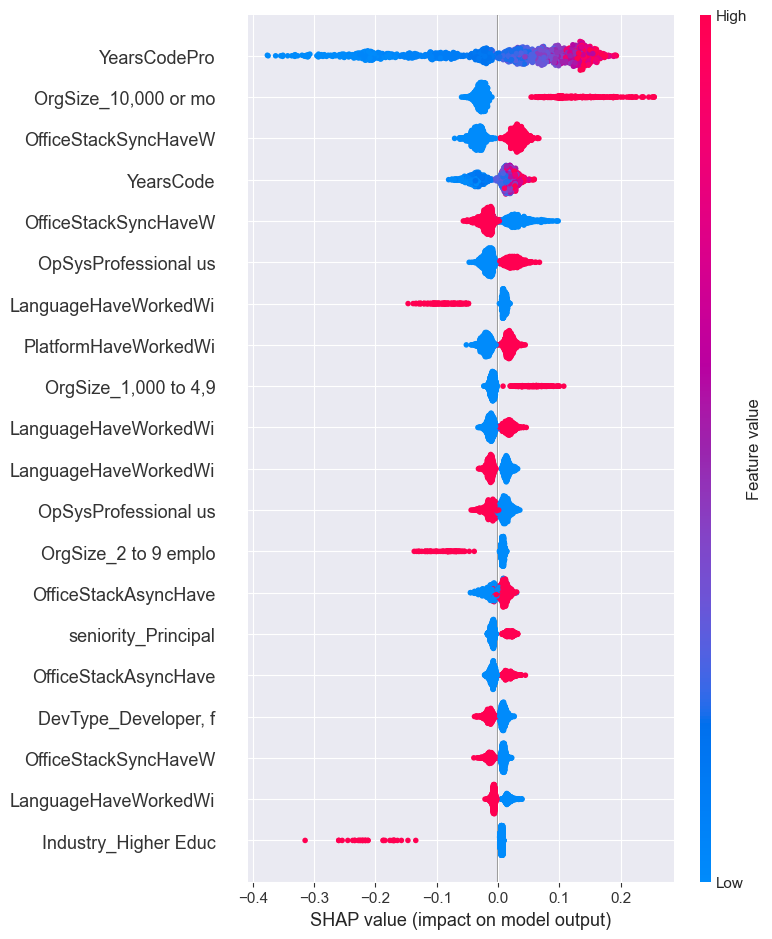

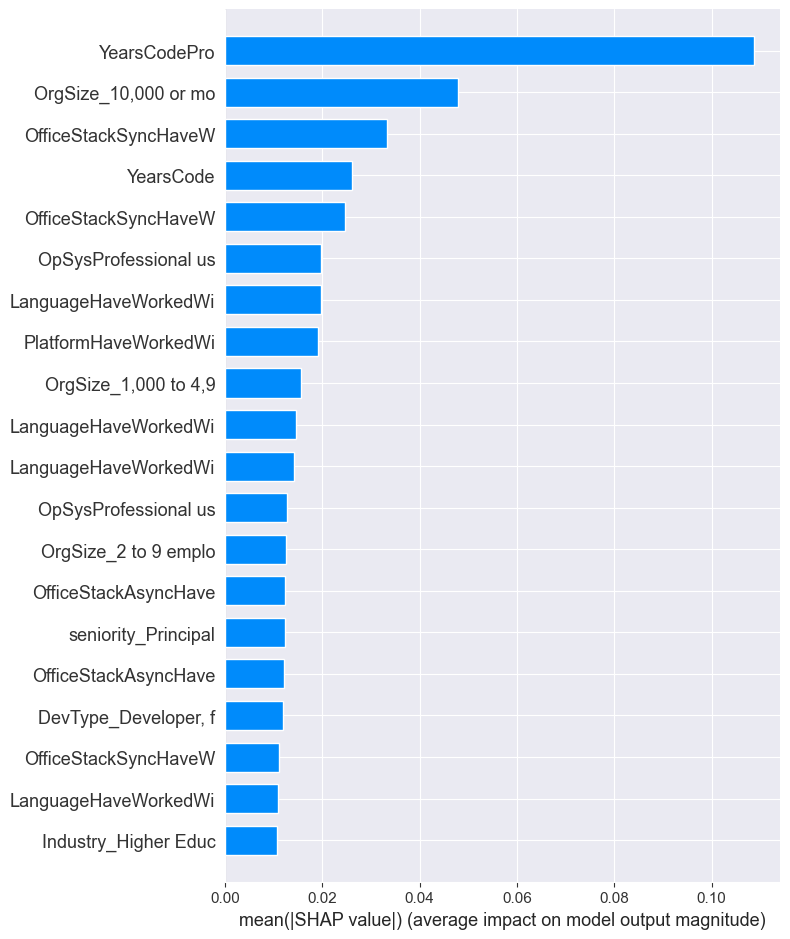

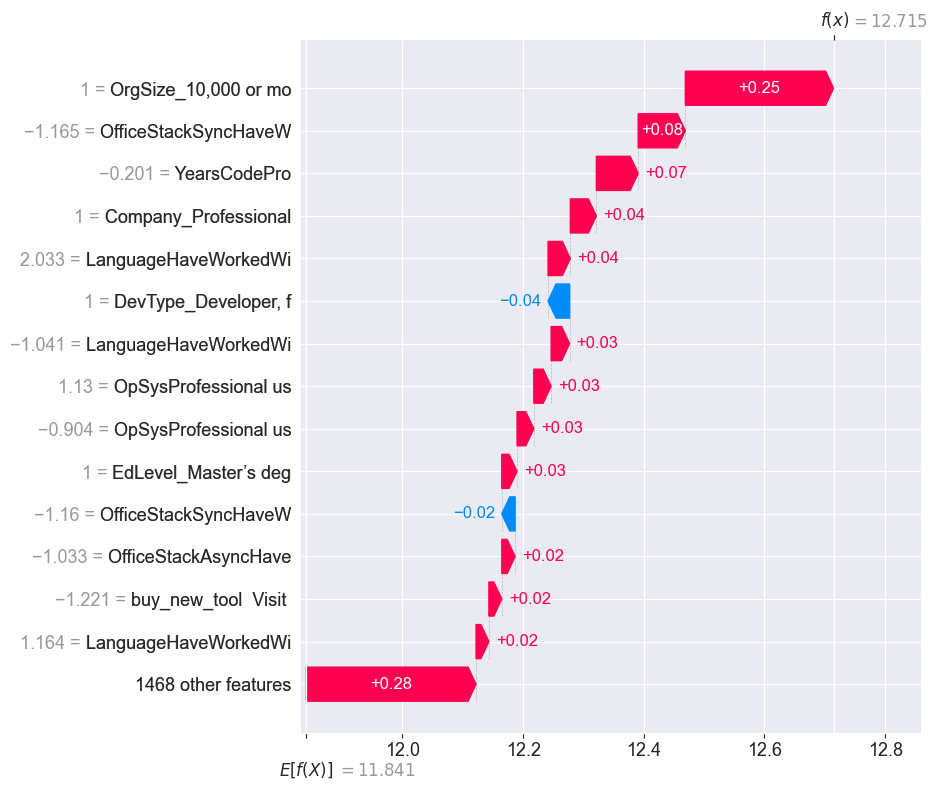

In [106]:
import shap
# -------- 8) SHAP analysis --------
print("\n=== Running SHAP analysis (this may take a few seconds) ===")
short_feature_names   = [x[:20] for x in feature_names]
# Transform X_test into the model input (after preprocessor)
X_test_trans = best_pipeline.named_steps["preprocessor"].transform(X_test)

# SHAP Explainer
explainer = shap.Explainer(final_model, X_test_trans, feature_names=short_feature_names)
shap_values = explainer(X_test_trans)

# Summary plot — top 20 features
shap.summary_plot(shap_values, X_test_trans, feature_names=short_feature_names, max_display=20)

# Bar plot for mean absolute SHAP values
shap.summary_plot(shap_values, X_test_trans, feature_names=short_feature_names, plot_type="bar", max_display=20)

# Optional: visualize SHAP for one specific prediction
idx = np.argmax(y_pred)  # example: the highest predicted salary
shap.plots.waterfall(shap_values[idx], max_display=15)

In [107]:
feature_names  = best_pipeline.named_steps["preprocessor"].get_feature_names_out()
final_ttr = best_pipeline.named_steps["model"]
final_model = getattr(final_ttr, "regressor_", final_ttr)
importances = final_model.feature_importances_
importance_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)
importance_df.head(30)

,Feature,Importance
1,YearsCodePro,1306
0,YearsCode,1148
3,WorkExp,918
358,OfficeStackSyncHaveWorkedWith Microsoft Teams,389
517,"OrgSize_10,000 or more employees",258
412,OpSysPersonal use Windows,248
48,buy_new_tool Visit developer communities like...,244
351,OfficeStackSyncHaveWorkedWith Discord,237
332,OfficeStackAsyncHaveWorkedWith Jira,233
380,AISearchDevHaveWorkedWith GitHub Copilot,227
